In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# 📊 Proyecto de Análisis de Sentimientos de Tweets-Leop

## 🎯 Problema de Negocio

El objetivo de este proyecto es analizar los sentimientos de los tweets, identificando si los mensajes son positivos o negativos. Utilizando un conjunto de datos de 1,600,000 tweets preprocesados, se pretende generar diversas características que se utilizarán para entrenar un modelo de clasificación.

## ❓ Preguntas Clave

- **¿Qué variables pueden ser clave para la detección del sentimiento?**
- **¿Qué tipo de modelos pueden servir para detectar el sentimiento en los tweets?**
- **¿Qué métricas se pueden utilizar para evaluar el desempeño del modelo?**

###  Instalación de dependencias

In [ ]:
!pip install vader
!pip install vaderSentiment
!pip install emoji --upgrade
!pip install unidecode

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.7 MB/s eta 0:00:00
  Created wheel for sonopy: filename=sonopy-0.1.2-py3-none-any.whl size=2851 sha256=ca928c321c4ef2e21f225198d84e04ebbdd688e45f891b64e8b2398efab81b21
  Stored in directory: /root/.cache/pip/wheels/6e/02/0d/df138747348c15908c1fb09493064ead497e16e187e3094d71
Successfully built sonopy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00


###  Importar bibliotecas y carga de dataframe

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import emoji
import unidecode
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import hstack
import joblib
import nltk
import math
from textblob import TextBlob
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer






# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Configurar pandas para ajustar el ancho total del DataFrame
pd.set_option('display.width', None)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cargar dataframe original

In [ ]:
# # Cargar el dataset de tweets
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/training_1600000_processed_noemoticon.csv", encoding='latin-1')
# df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
# df

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


##Función única para carga, limpieza y preprocesamiento de dataframe

In [ ]:
def preprocess_dataframe(df):
      # Cargar dataframe original
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/training_1600000_processed_noemoticon.csv", encoding='latin-1')
  df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

  # Eliminar la columna 'flag'(no relevante)
  df = df.drop(columns=['flag'])

  # Eliminar duplicados en las columnas 'text', 'ids' y 'date'
  df = df.drop_duplicates(subset=['text', 'ids', 'date'])

  # Convertir la columna 'date' a tipo de dato de fecha

  # Función para desglosar la fecha y extraer la información(tiene un formato extenso y vamos a extraer toda la información disponible)
  def desglosar_fecha(fecha):
    try:
        # Eliminar la zona horaria de la cadena de fecha
        partes = fecha.split()
        fecha_sin_tz = ' '.join(partes[:-2]) + ' ' + partes[-1]

        # Convertir el string a un objeto datetime sin zona horaria
        fecha_dt = datetime.strptime(fecha_sin_tz, "%a %b %d %H:%M:%S %Y")

        # Extraer componentes
        dia_semana = fecha_dt.strftime('%A')  # Día de la semana (ej: Monday)
        mes = fecha_dt.strftime('%B')         # Mes completo (ej: April)
        dia_mes = fecha_dt.day                # Día del mes (ej: 6)
        hora = fecha_dt.strftime('%H:%M:%S')  # Hora
        zona_horaria = partes[-2]             # Extraer la zona horaria manualmente
        año = fecha_dt.year                   # Año (ej: 2009)

        return dia_semana, mes, dia_mes, hora, zona_horaria, año

    except ValueError:  # Captura errores si el formato no coincide
        return None, None, None, None, None, None


    # Función para limpiar texto

  def clean_text(text):
      # Eliminar URLs
      text = re.sub(r"http\S+|www\S+|https\S+", '', text)
      # Eliminar menciones
      text = re.sub(r"@\w+", '', text)
      # Eliminar puntuaciones
      text = text.translate(str.maketrans('', '', string.punctuation))
      # Convertir a minúsculas
      text = text.lower()
      # Eliminar acentuaciones en portugués y otros idiomas
      text = unidecode.unidecode(text)
      # Eliminar símbolos de Copyright, Marca Registrada y otros símbolos extraños
      text = re.sub(r'[©®ï¿½]', '', text)
      # Eliminar caracteres no ASCII
      text = re.sub(r'[^\x00-\x7F]+', '', text)
      # Eliminar espacios adicionales
      text = re.sub(r'\s+', ' ', text).strip()
      return text


    # Función para calcular longitud del teewt
  def tweet_length(text):
    """
    Calcula la longitud del texto del tweet en su versión limpia (número de caracteres).
    Args:
    text (str): El texto del tweet en su versión limpia.
    Returns:
    int: La longitud del texto del tweet.
    """
    return len(text)

    # Función para extraer emojis
  def extract_emojis(text):
      return ''.join(c for c in text if emoji.is_emoji(c))

  # Función para contar emojis
  def count_emojis(text):
      return sum(1 for c in text if emoji.is_emoji(c))

  # Función para contar signos de exclamación
  def exclamation_count(text):
    """
    Cuenta cuántos signos de exclamación (!) hay en el tweet.
    Args:
    text (str): El texto del tweet.
    Returns:
    int: El número de signos de exclamación en el texto.
    """
    return text.count('!')

  # Función para contar signos de interrogación
  def question_count(text):
    """
    Cuenta cuántos signos de interrogación (?) hay en el tweet.
    Args:
    text (str): El texto del tweet.
    Returns:
    int: El número de signos de interrogación en el texto.
    """
    return text.count('?')

  # Aplicar las funciones al DataFrame
  df['cleaned_text'] = df['text'].apply(clean_text)
  df['tweet_length'] = df['cleaned_text'].apply(tweet_length)
  df['emojis'] = df['text'].apply(extract_emojis)
  df['emoji_count'] = df['text'].apply(count_emojis)
  df['exclamation_count'] = df['text'].apply(exclamation_count)
  df['question_count'] = df['text'].apply(question_count)

  # Desglosar la fecha y crear nuevas columnas
  df[['dia_semana', 'mes', 'dia_mes', 'hora', 'zona_horaria', 'año']] = df['date'].apply(
      lambda x: pd.Series(desglosar_fecha(str(x)))
  )

  return df


In [ ]:
df_clean=preprocess_dataframe(df)
df_clean

,target,ids,date,user,text,cleaned_text,tweet_length,emojis,emoji_count,exclamation_count,question_count,dia_semana,mes,dia_mes,hora,zona_horaria,año
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,104,,0,1,0,Monday,April,6,22:19:49,PDT,2009
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,76,,0,0,0,Monday,April,6,22:19:53,PDT,2009
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,46,,0,0,0,Monday,April,6,22:19:57,PDT,2009
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...,85,,0,0,1,Monday,April,6,22:19:57,PDT,2009
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew,not the whole crew,18,,0,0,0,Monday,April,6,22:20:00,PDT,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,54,,0,0,0,Tuesday,June,16,08:40:49,PDT,2009
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom very cool to hear old walt interview...,51,,0,1,0,Tuesday,June,16,08:40:49,PDT,2009
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,55,,0,0,1,Tuesday,June,16,08:40:49,PDT,2009
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time tup...,61,,0,3,0,Tuesday,June,16,08:40:49,PDT,2009


In [ ]:
#Guardar dataframe procesado

"""df_clean.to_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/df_clean.csv', index=False)"""


##Procesamiento paso a paso

###Revisión de duplicados antes de procesar

In [ ]:
# Contar el número de duplicados en las columnas 'ids', 'date', 'user' y 'text'
num_duplicados = df.duplicated(subset=['ids', 'date', 'user', 'text']).sum()
print(f'Número de duplicados en las columnas ids, date, user y text: {num_duplicados}')



Número de duplicados en las columnas ids, date, user y text: 1685


In [ ]:
# Filtrar el DataFrame para ver solo los registros duplicados en las columnas 'ids', 'date', 'user' y 'text'
registros_duplicados = df[df.duplicated(subset=['ids', 'date', 'user', 'text'], keep=False)]
print(registros_duplicados)


         target         ids                          date      flag          user  \
212           0  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY      DjGundam   
274           0  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY       iCalvin   
988           0  1468053611  Mon Apr 06 23:28:09 PDT 2009  NO_QUERY   mariejamora   
1176          0  1468100580  Mon Apr 06 23:42:57 PDT 2009  NO_QUERY   cristygarza   
1253          0  1468115720  Mon Apr 06 23:48:00 PDT 2009  NO_QUERY    WarholGirl   
...         ...         ...                           ...       ...           ...   
1598779       4  2193278017  Tue Jun 16 08:14:22 PDT 2009  NO_QUERY   janiecwales   
1599297       4  2193403830  Tue Jun 16 08:24:44 PDT 2009  NO_QUERY   lauren__x33   
1599384       4  2193428118  Tue Jun 16 08:26:44 PDT 2009  NO_QUERY     bubbles00   
1599439       4  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY  faiznurdavid   
1599930       4  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUE

In [ ]:
# Contar las frecuencias de los valores duplicados en las columnas 'ids', 'date', 'user' y 'text'
frecuencias_duplicados = df.groupby(['ids', 'date', 'user', 'text']).size().reset_index(name='count')
duplicados = frecuencias_duplicados[frecuencias_duplicados['count'] > 1]
print

In [ ]:
df[df['user']=='emma_b_xox']

,target,ids,date,flag,user,text
422434,0,2062642071,Sat Jun 06 23:50:35 PDT 2009,NO_QUERY,emma_b_xox,@Lazy_kitty i am sorry if i dont reply to you ...
524687,0,2193576442,Tue Jun 16 08:38:45 PDT 2009,NO_QUERY,emma_b_xox,Had an injection today. Not fun the rrst of t...
665097,0,2244750098,Fri Jun 19 15:09:56 PDT 2009,NO_QUERY,emma_b_xox,Night night! I have to revise tomorrow and i a...
1599930,4,2193576442,Tue Jun 16 08:38:45 PDT 2009,NO_QUERY,emma_b_xox,Had an injection today. Not fun the rrst of t...


Se encontró coincidencia en 1685 registros que tienen la misma información en en toda la estructura del tweet, fecha y usuario, por lo que no hay duda de que son duplicados que serán eliminados del análisis.

---


### El dataset contiene texto que se puede considerar como "sucio", es por ello que partamos de crear una función que pueda limpiar este texto eliminando URLs, menciones, emojis y caracteres especiales.
Recuerda que la limpieza de texto es crucial para que el análisis sea más preciso.

In [ ]:
   # Aquí el alumno debe eliminar URLs del texto usando expresiones regulares.
    # También se debe eliminar las menciones de otros usuarios en el texto (@usuario).
    # Es importante eliminar los emojis y convertir todo el texto a minúsculas.

def clean_text(text):
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    # Eliminar menciones
    text = re.sub(r"@\w+", '', text)
    # Eliminar puntuaciones
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar acentuaciones en portugués y otros idiomas
    text = unidecode.unidecode(text)
    # Eliminar símbolos de Copyright, Marca Registrada y otros símbolos extraños
    text = re.sub(r'[©®ï¿½]', '', text)
    # Eliminar caracteres no ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Eliminar espacios adicionales
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

### Longitud del tweet: se debe calcular la longitud del texto del tweet en su versión limpia (número de caracteres).
Esta característica es útil porque podría revelar patrones sobre la longitud y el contenido de los tweets.

In [ ]:
def tweet_length(text):
    """
    Calcula la longitud del texto del tweet en su versión limpia (número de caracteres).
    Args:
    text (str): El texto del tweet en su versión limpia.
    Returns:
    int: La longitud del texto del tweet.
    """
    return len(text)

# Aplicando al DataFrame
df['tweet_length'] = df['cleaned_text'].apply(tweet_length)

# Mostrar las primeras 10 filas
print(df[['cleaned_text', 'tweet_length']].head(10))




                                        cleaned_text  tweet_length
0  is upset that he cant update his facebook by t...           105
1   i dived many times for the ball managed to sa...            78
2    my whole body feels itchy and like its on fire             47
3   no its not behaving at all im mad why am i he...            87
4                                not the whole crew             20
5                                        need a hug             11
6   hey  long time no see yes rains a bit only a ...            81
7                           nope they didnt have it             25
8                                     que me muera              15
9            spring break in plain city its snowing             39


### Contar emojis: en algunos casos, los emojis pueden representar emociones, por lo tanto, contamos cuántos emojis hay en el tweet.
La función debe recorrer cada carácter del texto y contar cuántos son emojis.

In [ ]:
# Función para extraer emojis
def extract_emojis(text):
    return ''.join(c for c in text if emoji.is_emoji(c))

# Función para contar emojis
def count_emojis(text):
    return sum(1 for c in text if emoji.is_emoji(c))

df['emoji_count'] = df['text'].apply(count_emojis)

### Contar signos de exclamación e interrogación: los tweets con muchos signos de exclamación o interrogación podrían indicar emoción o sorpresa.

In [ ]:
def exclamation_count(text):
    """
    Cuenta cuántos signos de exclamación (!) hay en el tweet.
    Args:
    text (str): El texto del tweet.
    Returns:
    int: El número de signos de exclamación en el texto.
    """
    return text.count('!')

def question_count(text):
    """
    Cuenta cuántos signos de interrogación (?) hay en el tweet.
    Args:
    text (str): El texto del tweet.
    Returns:
    int: El número de signos de interrogación en el texto.
    """
    return text.count('?')

df['exclamation_count'] = df['text'].apply(exclamation_count)
df['question_count'] = df['text'].apply(question_count)

# Mostrar las primeras 10 filas
print(df[['text', 'exclamation_count', 'question_count']].head(10))

                                                text  exclamation_count  \
0  is upset that he can't update his Facebook by ...                  1   
1  @Kenichan I dived many times for the ball. Man...                  0   
2    my whole body feels itchy and like its on fire                   0   
3  @nationwideclass no, it's not behaving at all....                  0   
4                      @Kwesidei not the whole crew                   0   
5                                        Need a hug                   0   
6  @LOLTrish hey  long time no see! Yes.. Rains a...                  1   
7               @Tatiana_K nope they didn't have it                   0   
8                          @twittera que me muera ?                   0   
9        spring break in plain city... it's snowing                   0   

   question_count  
0               0  
1               0  
2               0  
3               1  
4               0  
5               0  
6               1  
7             

### Conversión de Fecha

In [ ]:
  # Convertir la columna 'date' a tipo de dato de fecha

  # Función para desglosar la fecha y extraer la información(tiene un formato extenso y vamos a extraer toda la información disponible)
def desglosar_fecha(fecha):
  try:
      # Eliminar la zona horaria de la cadena de fecha
      partes = fecha.split()
      fecha_sin_tz = ' '.join(partes[:-2]) + ' ' + partes[-1]

      # Convertir el string a un objeto datetime sin zona horaria
      fecha_dt = datetime.strptime(fecha_sin_tz, "%a %b %d %H:%M:%S %Y")

      # Extraer componentes
      dia_semana = fecha_dt.strftime('%A')  # Día de la semana (ej: Monday)
      mes = fecha_dt.strftime('%B')         # Mes completo (ej: April)
      dia_mes = fecha_dt.day                # Día del mes (ej: 6)
      hora = fecha_dt.strftime('%H:%M:%S')  # Hora
      zona_horaria = partes[-2]             # Extraer la zona horaria manualmente
      año = fecha_dt.year                   # Año (ej: 2009)

      return dia_semana, mes, dia_mes, hora, zona_horaria, año

  except ValueError:  # Captura errores si el formato no coincide
      return None, None, None, None, None, None

### Función para verificación general del dataframe

In [ ]:
def verificacion(dataframe):
  global df_clean
    # Verificar valores nulos
  print("Valores nulos por columna:")
  print(dataframe.isnull().sum())
  print("\n")

  # Verificar duplicados
  duplicados = dataframe.duplicated()
  df_duplicados = dataframe[duplicados]
  if not df_duplicados.empty:
      print("Filas duplicadas:")
      print(df_duplicados)
      print("\n")

  # Contar valores únicos en cada columna
  print("Conteo de valores únicos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].nunique()} valores únicos")
      print(f"Valores únicos en '{columna}':")
      #print(dataframe[columna].unique())
      print("\n")

  # Verificar tipos de datos por columna
  print("\nTipos de datos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].dtype}")

  # Verificar tipos de datos y buscar caracteres especiales
  for columna in dataframe.select_dtypes(include=['object', 'string']).columns:
      print(f"\nVerificando inconsistencias en la columna '{columna}':")
      inconsistencias = dataframe[dataframe[columna].apply(lambda x: not all(ord(c) < 128 for c in str(x)))]
      if not inconsistencias.empty:
          print(inconsistencias)
          print("\n")

  #Verificar Nan en todo el dataset
  print("Valores NaN por columna:")
  df_nan = dataframe[dataframe.isna().any(axis=1)]
  print(df_nan.head())
  print("\n")

### Verificar limpieza de texto en cleaned_text

In [ ]:
# Aplicar la función de verificación SOLO a la columna 'cleaned_text'
columna = 'cleaned_text'
print(f"\nVerificando inconsistencias en la columna '{columna}':")
inconsistencias = df_clean[df_clean[columna].apply(lambda x: not all(ord(c) < 128 for c in str(x)))]
if not inconsistencias.empty:
    print(inconsistencias)
    print("\n")

# Cargar dataframe procesado

In [ ]:
df_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/df_clean.csv')
df_clean.info()


<ipython-input-14-b9aae873e408>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/df_clean.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598314 entries, 0 to 1598313
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   target             1598314 non-null  int64 
 1   ids                1598314 non-null  int64 
 2   date               1598314 non-null  object
 3   user               1598314 non-null  object
 4   text               1598314 non-null  object
 5   cleaned_text       1595150 non-null  object
 6   tweet_length       1598314 non-null  int64 
 7   emojis             954 non-null      object
 8   emoji_count        1598314 non-null  int64 
 9   exclamation_count  1598314 non-null  int64 
 10  question_count     1598314 non-null  int64 
 11  dia_semana         1598314 non-null  object
 12  mes                1598314 non-null  object
 13  dia_mes            1598314 non-null  int64 
 14  hora               1598314 non-null  object
 15  zona_horaria       1598314 non-null  object
 16  

###Explorando Nulos en cleaned_text

In [ ]:
# Mostrar los registros con valores nulos en la columna 'cleaned_text'
null_cleaned_text = df_clean[df_clean['cleaned_text'].isnull()]
null_cleaned_text


,target,ids,date,user,text,cleaned_text,tweet_length,emojis,emoji_count,exclamation_count,question_count,dia_semana,mes,dia_mes,hora,zona_horaria,año
207,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,Artiel87,@mandayyy,NaN,0,NaN,0,0,0,Monday,April,6,22:33:25,PDT,2009
248,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,Artiel87,@mandayyy,NaN,0,NaN,0,0,0,Monday,April,6,22:36:27,PDT,2009
281,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,__Susan__,@ITS_NEMESIS -------,NaN,0,NaN,0,0,0,Monday,April,6,22:38:20,PDT,2009
397,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,KimberlyKane,@danadearmond,NaN,0,NaN,0,0,0,Monday,April,6,22:46:53,PDT,2009
429,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,jtmal0723,@anistorm,NaN,0,NaN,0,0,0,Monday,April,6,22:48:48,PDT,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594992,4,2192743346,Tue Jun 16 07:29:14 PDT 2009,vmslive,@Catherine_Smith,NaN,0,NaN,0,0,0,Tuesday,June,16,07:29:14,PDT,2009
1595647,4,2192910190,Tue Jun 16 07:43:42 PDT 2009,senoritaperdida,@ashtonshay00,NaN,0,NaN,0,0,0,Tuesday,June,16,07:43:42,PDT,2009
1596005,4,2192984835,Tue Jun 16 07:50:07 PDT 2009,upontheshelf,@patty4sound http://twitpic.com/7iuns -,NaN,0,NaN,0,0,0,Tuesday,June,16,07:50:07,PDT,2009
1597809,4,2193453573,Tue Jun 16 08:28:48 PDT 2009,RobNice24,@Sworn4DaBosses,NaN,0,NaN,0,0,0,Tuesday,June,16,08:28:48,PDT,2009


In [ ]:
df_clean = df_clean.dropna(subset=['cleaned_text']) #Borrar los nulos que quedaron luego de la limpieza. Identificados en la exploración como @xxxxx(varios nombres de usuarios)
df_clean['hora'] = pd.to_datetime(df_clean['hora'], format='%H:%M:%S', errors='coerce')

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1595150 entries, 0 to 1598313
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   target             1595150 non-null  int64         
 1   ids                1595150 non-null  int64         
 2   date               1595150 non-null  object        
 3   user               1595150 non-null  object        
 4   text               1595150 non-null  object        
 5   cleaned_text       1595150 non-null  object        
 6   tweet_length       1595150 non-null  int64         
 7   emojis             954 non-null      object        
 8   emoji_count        1595150 non-null  int64         
 9   exclamation_count  1595150 non-null  int64         
 10  question_count     1595150 non-null  int64         
 11  dia_semana         1595150 non-null  object        
 12  mes                1595150 non-null  object        
 13  dia_mes            1595150 non-n

In [ ]:
df_clean.head()

,target,ids,date,user,text,cleaned_text,tweet_length,emojis,emoji_count,exclamation_count,question_count,dia_semana,mes,dia_mes,hora,zona_horaria,año
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,104,NaN,0,1,0,Monday,April,6,1900-01-01 22:19:49,PDT,2009
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,76,NaN,0,0,0,Monday,April,6,1900-01-01 22:19:53,PDT,2009
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,46,NaN,0,0,0,Monday,April,6,1900-01-01 22:19:57,PDT,2009
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...,85,NaN,0,0,1,Monday,April,6,1900-01-01 22:19:57,PDT,2009
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew,not the whole crew,18,NaN,0,0,0,Monday,April,6,1900-01-01 22:20:00,PDT,2009


## Es tu turno! ¿Qué otras variables se te ocurren para poder construir un modelo que pueda predecir el sentimiento del tweet?

1. Variables clave para la detección del sentimiento
Las siguientes variables son relevantes para el análisis de sentimiento:

Variables principales (texto):

text: Texto crudo del tweet (requiere limpieza adicional si hay ruido).

cleaned_text: Texto preprocesado (ideal para entrenar modelos, aunque tiene algunos valores nulos que deben manejarse).

Variables contextuales/metadatos:

emojis: Emojis presentes (pueden reforzar el sentimiento, pero están mayormente vacíos, solo 954 valores no nulos).

emoji_count: Número de emojis (más útil que la columna emojis).

exclamation_count y question_count: Cantidad de signos de exclamación/interrogación (indicadores de intensidad emocional).

tweet_length: Longitud del tweet (tweets largos pueden contener más contexto).

hora, dia_semana, mes: Variables temporales (para analizar patrones de sentimiento a lo largo del tiempo).

Variable objetivo:

target: Asumo que es la etiqueta de sentimiento (ej: 0 = negativo, 4 = positivo, si sigue el estándar de datasets como Sentiment140). ¡Verifica esto!

2. Modelos para detectar sentimiento en tweets
Dado que el dataset está en inglés y es grande (~1.6M filas), estos modelos son adecuados:

Modelos clásicos (basados en features manuales):

Regresión Logística / SVM: Con embeddings como TF-IDF + variables numéricas (emoji_count, exclamation_count, etc.).

Naive Bayes: Útil para clasificación rápida con datos de texto.

Modelos de Deep Learning (basados en transformers):

BERT / RoBERTa: Modelos pre-entrenados en inglés (ej: bert-base-uncased, roberta-base).

DistilBERT: Versión ligera de BERT para entrenamiento más rápido.

LSTM/GRU: Con embeddings como Word2Vec o GloVe (menos eficientes que transformers).

Librerías recomendadas:

transformers (Hugging Face) para modelos pre-entrenados.

scikit-learn para modelos clásicos.

3. Métricas para evaluar el modelo
Dependen del balance de clases en target:

Si las clases están balanceadas:

Accuracy: Precisión general.

Matriz de confusión: Para ver falsos positivos/negativos.

Si hay desbalance:

F1-Score: Media armónica entre precisión y recall (ideal para clases minoritarias).

Precision/Recall: Prioriza según el objetivo (ej: evitar falsos positivos).

AUC-ROC: Evalúa el rendimiento en todos los umbrales de clasificación.

Métricas específicas para NLP:

Perplexity (para modelos generativos).

BLEU Score (si se compara con textos de referencia).

Consideraciones adicionales del dataset
Problemas detectados:

La columna emojis está casi vacía: Considera eliminarla o usar solo emoji_count.

cleaned_text tiene valores nulos: Elimina filas con cleaned_text nulo o rellena con text.

target debe validarse: Asegúrate de que los valores (ej: 0, 4) correspondan a sentimientos claros.

Recomendación inicial:

Limpiar datos (manejar nulos en cleaned_text).

Explorar distribución de target (¿hay desbalance?).

Empezar con un modelo clásico (Regresión Logística + TF-IDF) como línea base.

Mejorar con BERT/RoBERTa para mayor precisión.

**Existen librerías que ya detectan los sentimientos de texto, crees que debas de usarlas?**

In [ ]:
df_clean.to_csv('datatotal.csv')

#Implememtació de ML

## 1. Aplicación básica de ***Textblob*** a cleaned_Text y análisis de resultado(opción de muestra aleatoria)

***
 "Miramos dos cosas en los tweets: cómo se sienten y qué tan personales son. Para 'cómo se sienten', les damos un puntaje de -1 (triste) a 1 (feliz), y si está en el medio (0), es neutral. Para 'qué tan personales son', va de 0 (solo hechos) a 1 (pura opinión). Luego hacemos gráficos: barras y un pastel para contar los sentimientos, y dos curvas que muestran cómo se reparten esos puntajes. Así vemos si los tweets son más felices o tristes, y si son más fríos o llenos de emoción."
 ***

Resumen de sentimientos:
sentimiento
Positivo    684595
Neutral     567149
Negativo    343406
Name: count, dtype: int64


<ipython-input-31-879e3dc4940d>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento', data=data, order=['Positivo', 'Neutral', 'Negativo'], palette='viridis')


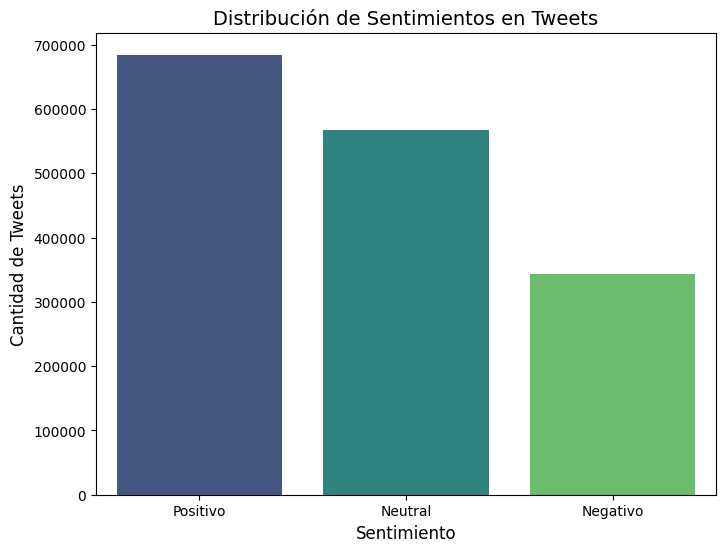

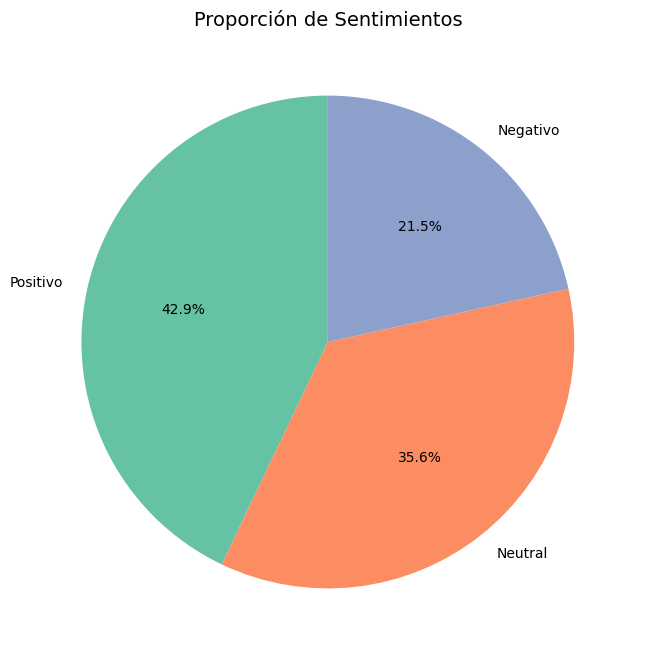

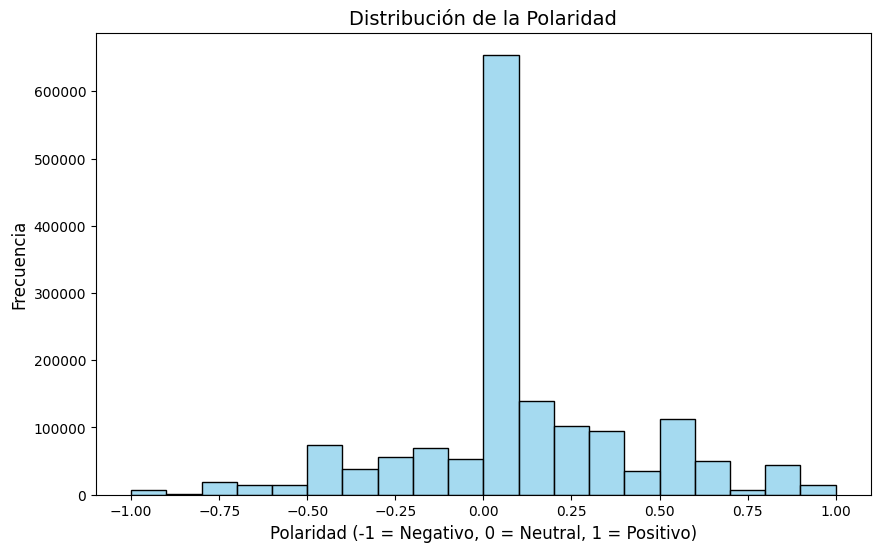

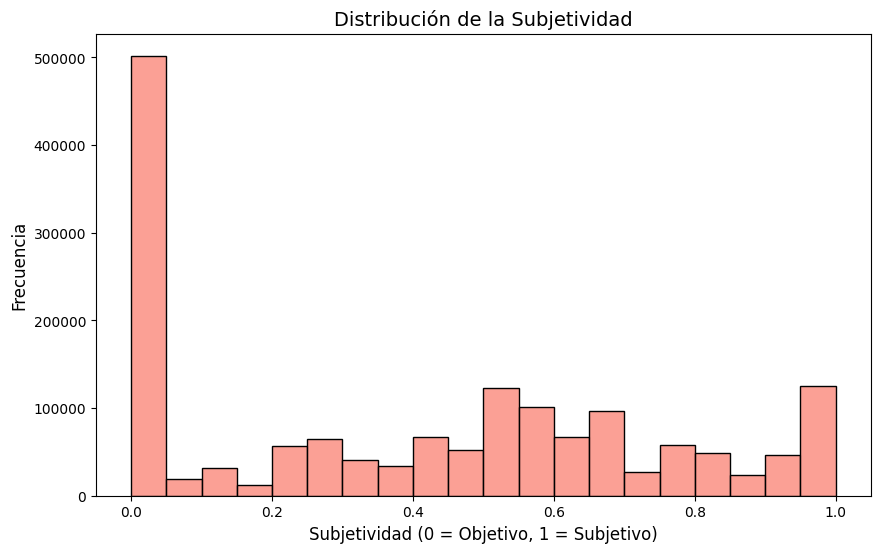


Ejemplos de tweets con polaridad y subjetividad:
                                        cleaned_text sentimiento  polaridad  subjetividad
0  is upset that he cant update his facebook by t...     Neutral      0.000           0.0
1  i dived many times for the ball managed to sav...    Positivo      0.500           0.5
2     my whole body feels itchy and like its on fire    Positivo      0.200           0.4
3  no its not behaving at all im mad why am i her...    Negativo     -0.625           1.0
4                                 not the whole crew    Positivo      0.200           0.4


In [ ]:
# Cargamos el archivo desde la ruta especificada
ruta = '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv'
data = pd.read_csv(ruta, usecols=['cleaned_text'])

# Tomamos una muestra de 10,000 tweets
#data = data.sample(n=100000, random_state=42)

# Función para analizar polaridad y subjetividad
def analizar_sentimiento(tweet):
    try:
        analisis = TextBlob(str(tweet))
        polaridad = analisis.sentiment.polarity  # De -1 a 1
        subjetividad = analisis.sentiment.subjectivity  # De 0 a 1

        # Clasificación de polaridad
        if polaridad > 0:
            sentimiento = 'Positivo'
        elif polaridad < 0:
            sentimiento = 'Negativo'
        else:
            sentimiento = 'Neutral'

        return pd.Series([sentimiento, polaridad, subjetividad])
    except:
        return pd.Series(['Neutral', 0, 0])

# Aplicamos el análisis y creamos tres columnas nuevas
data[['sentimiento', 'polaridad', 'subjetividad']] = data['cleaned_text'].apply(analizar_sentimiento)

# Guardamos el resultado en Drive
# data.to_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/df_clean_con_sentimiento.csv', index=False)

# Resumen numérico
print("Resumen de sentimientos:")
resumen = data['sentimiento'].value_counts()
print(resumen)

# Visualización 1: Gráfico de barras de sentimientos
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimiento', data=data, order=['Positivo', 'Neutral', 'Negativo'], palette='viridis')
plt.title('Distribución de Sentimientos en Tweets', fontsize=14)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Cantidad de Tweets', fontsize=12)
plt.show()

# Visualización 2: Gráfico de pastel de sentimientos
plt.figure(figsize=(8, 8))
plt.pie(resumen, labels=resumen.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'], startangle=90)
plt.title('Proporción de Sentimientos', fontsize=14)
plt.show()

# Visualización 3: Distribución de polaridad
plt.figure(figsize=(10, 6))
sns.histplot(data['polaridad'], bins=20, color='skyblue')
plt.title('Distribución de la Polaridad', fontsize=14)
plt.xlabel('Polaridad (-1 = Negativo, 0 = Neutral, 1 = Positivo)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

# Visualización 4: Distribución de subjetividad
plt.figure(figsize=(10, 6))
sns.histplot(data['subjetividad'], bins=20, color='salmon')
plt.title('Distribución de la Subjetividad', fontsize=14)
plt.xlabel('Subjetividad (0 = Objetivo, 1 = Subjetivo)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

# Mostramos algunos ejemplos
print("\nEjemplos de tweets con polaridad y subjetividad:")
print(data[['cleaned_text', 'sentimiento', 'polaridad', 'subjetividad']].head())

In [ ]:
# Tweets más positivos
print("\nTweets más positivos:")
print(data.sort_values('polaridad', ascending=False)['cleaned_text'].head(3))

# Tweets más negativos
print("\nTweets más negativos:")
print(data.sort_values('polaridad')['cleaned_text'].head(3))

# Tweets más subjetivos
print("\nTweets más subjetivos:")
print(data.sort_values('subjetividad', ascending=False)['cleaned_text'].head(3))


Tweets más positivos:
1275306    move to austin already sheesh we got nothing b...
427412     windows vista sp2 internet access with fix ip ...
1560355                                that would be awesome
Name: cleaned_text, dtype: object

Tweets más negativos:
422101    there is no warp command in inventor pathetic ...
320253                  omg my hay fever is awful this year
299288    we seem to get the worst ones here like f5s in...
Name: cleaned_text, dtype: object

Tweets más subjetivos:
797575    oh no i knew about her condition but its still...
583436                   im so sad i have to leave tomorrow
583332    needless to say i am extremely worried as we h...
Name: cleaned_text, dtype: object


Explicación de Polaridad y Subjetividad
1. Polaridad
¿Qué es?: La polaridad mide si un texto suena positivo, negativo o neutral. Es como preguntar: "¿Este tweet está feliz, triste o no dice mucho?"
Rango: Va de -1 a 1.
-1: Muy negativo (ejemplo: "Odio todo, qué día horrible").
0: Neutral (ejemplo: "Hoy es lunes").
1: Muy positivo (ejemplo: "¡Amo este día soleado!").
Por qué este rango?: TextBlob usa un sistema basado en palabras con valores predefinidos (como un diccionario de emociones). Si encuentra palabras negativas ("triste", "malo"), baja el puntaje; si encuentra positivas ("feliz", "genial"), lo sube. El resultado es un número entre -1 y 1 que refleja el "humor" general del texto.
Clasificación en el código:
Mayor a 0 = "Positivo".
Menor a 0 = "Negativo".
Igual a 0 = "Neutral".
Por qué usarlo?: Nos ayuda a saber rápidamente si la gente está más contenta o molesta en Twitter.
2. Subjetividad
¿Qué es?: La subjetividad mide cuánto de opinión personal hay en el texto. Es como preguntar: "¿Esto es un hecho frío o una opinión fuerte?"
Rango: Va de 0 a 1.
0: Muy objetivo (ejemplo: "El cielo es azul").
1: Muy subjetivo (ejemplo: "El cielo es el más hermoso que he visto").
Por qué este rango?: TextBlob analiza si el texto tiene palabras que suenan como hechos (más concretas) o como sentimientos y opiniones (más personales). Un valor cerca de 0 significa que es más un dato; cerca de 1, que es pura emoción o juicio.
Por qué usarlo?: Nos dice si los tweets son más informativos o emocionales, lo cual complementa la polaridad. Por ejemplo, un tweet negativo objetivo ("El tren se retrasó") es diferente a uno subjetivo ("Odio este tren horrible").
Ejemplo práctico
Tweet: "is upset that he cant update his facebook"
Polaridad: Negativa (-0.25 aprox.), porque "upset" es triste.
Subjetividad: Alta (0.75 aprox.), porque refleja un sentimiento personal.



## 1. Aplicación de ***VADER*** a cleaned_Text y análisis de resultado(opción de muestra aleatoria)

* Explicación de VADER y sus valores

*¿Qué es VADER?*

VADER es como un "detector de emociones" especial para redes sociales. Está entrenado para entender palabras comunes en tweets, como "jaja", ":(", o "genial", y sabe cuánto pesan emocionalmente.

Puntaje Compuesto (Compound):

Rango: Va de -1 a 1.
-1: Muy negativo (ejemplo: "Odio este día horrible").
0: Neutral (ejemplo: "Hoy es lunes").
1: Muy positivo (ejemplo: "¡Amo este día increíble!").

*Por qué este rango?:*

VADER mira las palabras del tweet y les da un puntaje según un diccionario especial. Luego combina todo en un número único (el "compound") que nos dice si el tweet es más feliz o triste. Los umbrales (0.05 y -0.05) son como líneas imaginarias que separan lo neutral de lo positivo o negativo.

*Por qué usarlo?:*

Es más rápido y está hecho para textos como tweets, donde hay emojis, jerga o frases cortas.

* Diferencia con TextBlob

TextBlob usa polaridad (-1 a 1) y subjetividad (0 a 1), pero VADER solo da el "compound" y es mejor con lenguaje informal.
No mide subjetividad, así que nos enfocamos solo en si el tweet es positivo, negativo o neutral.

Resumen de sentimientos:
sentimiento
Positivo    741901
Neutral     430246
Negativo    423003
Name: count, dtype: int64


<ipython-input-38-2d4f236b71dd>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento', data=data, order=['Positivo', 'Neutral', 'Negativo'], palette='viridis')


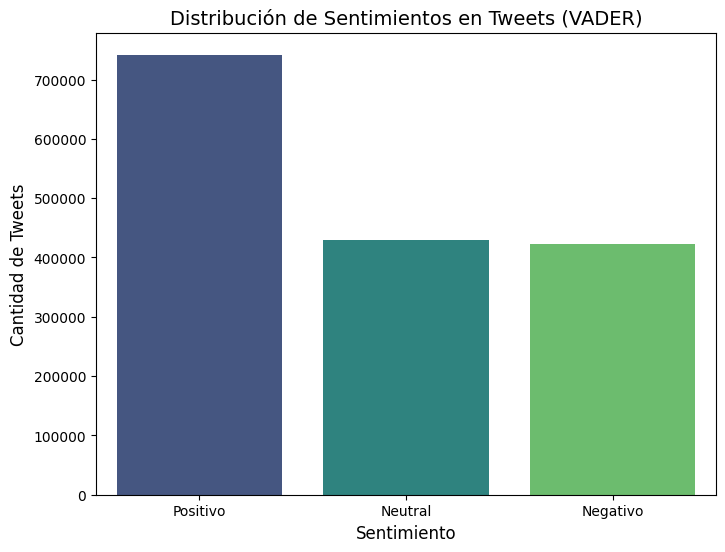

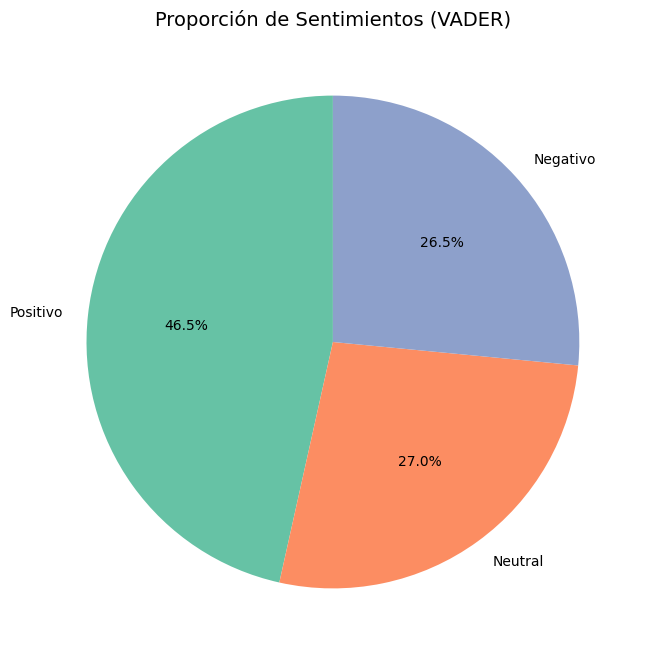

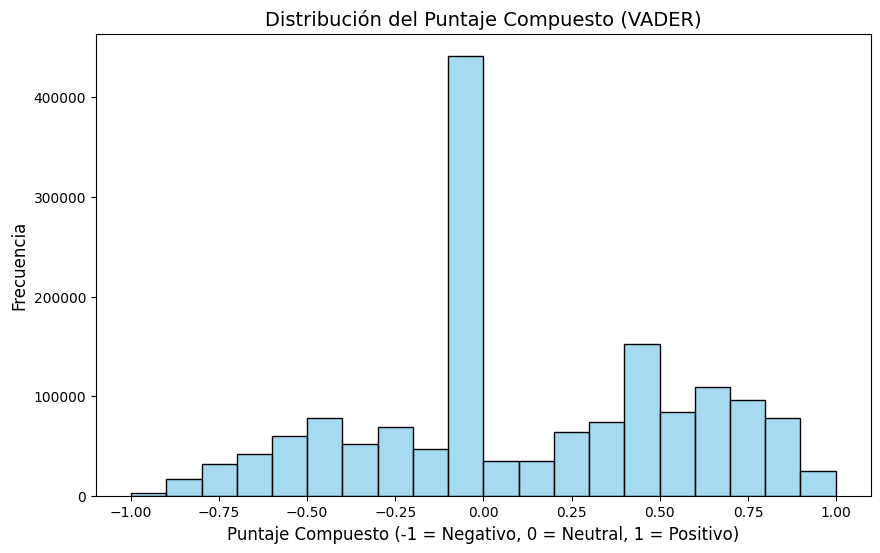


Ejemplos de tweets con sentimiento y puntaje compuesto:
                                        cleaned_text sentimiento  compound
0  is upset that he cant update his facebook by t...    Negativo   -0.7269
1  i dived many times for the ball managed to sav...    Positivo    0.4939
2     my whole body feels itchy and like its on fire    Negativo   -0.2500
3  no its not behaving at all im mad why am i her...    Negativo   -0.6597
4                                 not the whole crew     Neutral    0.0000


In [ ]:
# Cargamos el archivo desde la ruta especificada
ruta = '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv'
data = pd.read_csv(ruta, usecols=['cleaned_text'])

# Tomamos una muestra de 10,000 tweets (descomenta la línea si quieres una muestra mayor)
# data = data.sample(n=10000, random_state=42)
# data = data.sample(n=100000, random_state=42)  # Si quieres 100,000, descomenta esta línea

# Creamos el analizador de VADER
analyzer = SentimentIntensityAnalyzer()

# Función para analizar el sentimiento con VADER
def analizar_sentimiento(tweet):
    try:
        # VADER nos da un diccionario con puntajes
        scores = analyzer.polarity_scores(str(tweet))
        compound = scores['compound']  # Puntaje compuesto de -1 a 1

        # Clasificación basada en el puntaje compuesto
        if compound > 0.05:
            sentimiento = 'Positivo'
        elif compound < -0.05:
            sentimiento = 'Negativo'
        else:
            sentimiento = 'Neutral'

        return pd.Series([sentimiento, compound])
    except:
        return pd.Series(['Neutral', 0])

# Aplicamos el análisis y creamos dos columnas nuevas
data[['sentimiento', 'compound']] = data['cleaned_text'].apply(analizar_sentimiento)

# Guardamos el resultado en Drive
# data.to_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/df_clean_con_sentimiento_vader.csv', index=False)

# Resumen numérico
print("Resumen de sentimientos:")
resumen = data['sentimiento'].value_counts()
print(resumen)

# Visualización 1: Gráfico de barras de sentimientos
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimiento', data=data, order=['Positivo', 'Neutral', 'Negativo'], palette='viridis')
plt.title('Distribución de Sentimientos en Tweets (VADER)', fontsize=14)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Cantidad de Tweets', fontsize=12)
plt.show()

# Visualización 2: Gráfico de pastel de sentimientos
plt.figure(figsize=(8, 8))
plt.pie(resumen, labels=resumen.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'], startangle=90)
plt.title('Proporción de Sentimientos (VADER)', fontsize=14)
plt.show()

# Visualización 3: Distribución del puntaje compuesto
plt.figure(figsize=(10, 6))
sns.histplot(data['compound'], bins=20, color='skyblue')
plt.title('Distribución del Puntaje Compuesto (VADER)', fontsize=14)
plt.xlabel('Puntaje Compuesto (-1 = Negativo, 0 = Neutral, 1 = Positivo)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

# Mostramos algunos ejemplos
print("\nEjemplos de tweets con sentimiento y puntaje compuesto:")
print(data[['cleaned_text', 'sentimiento', 'compound']].head())

***
Usamos una herramienta llamada VADER, que es como un amigo que lee tweets y nos dice si están felices, tristes o normales. Mira cada mensaje y le da un puntaje de -1 (supertriste) a 1 (superfeliz). Si el puntaje es alto, decimos 'Positivo'; si es bajo, 'Negativo'; y si está en el medio, 'Neutral'. Luego contamos cuántos tweets hay de cada tipo y hacemos gráficos: barras para ver las cantidades, un pastel para los porcentajes, y una curva para mostrar cómo se reparten los puntajes. Así sabemos rápido qué siente la gente en Twitter.
***

In [ ]:
# Mostrar los 3 tweets más positivos
print("\nLos 3 tweets más positivos:")
top_positivos = data.nlargest(3, 'compound')[['cleaned_text', 'compound']]
print(top_positivos)

# Mostrar los 3 tweets más negativos
print("\nLos 3 tweets más negativos:")
top_negativos = data.nsmallest(3, 'compound')[['cleaned_text', 'compound']]
print(top_negativos)




Los 3 tweets más positivos:
                                              cleaned_text  compound
1175753  is what gets me through the day lt3 ily ily il...    0.9987
777026   i love you yoo i love you love you love you i ...    0.9929
1263959  ahhh such a great day love love love love love...    0.9910

Los 3 tweets más negativos:
                                             cleaned_text  compound
403850  shit shit shit shit shit shit shit shit shit s...   -0.9985
385243  fuck fuck fuck fuck fuck fuck fuck fuck fuck f...   -0.9978
615231  bad bad bad bad bad bad bad bad bad bad bad ba...   -0.9967


## 3. Creación Modelo de ***XGBoost*** a cleaned_Text y análisis de resultado(opción de muestra aleatoria)

#### Creando Datos de entrenamiento

In [ ]:
# Cargamos el archivo desde la ruta especificada
ruta = '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv'
data = pd.read_csv(ruta, usecols=['cleaned_text', 'target'])  # Incluimos 'target' como etiqueta

# Convertimos el target: 0 = Negativo, 4 a 1 = Positivo
data['target'].replace({4: 1}, inplace=True)

# Definimos X (textos) e y (etiquetas)
X = data['cleaned_text']
y = data['target']

# Verificamos dimensiones iniciales
print(f"Dimensión de X (variables predictoras): {X.shape}")
print(f"Dimensión de y (variable objetivo): {y.shape}")

# Convertimos texto a características numéricas con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limitamos a 5000 palabras más frecuentes
X = vectorizer.fit_transform(X)

# Dividimos en train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividimos temp en test (50%) y validation (50%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verificamos dimensiones después del split
print(f"Conjunto de entrenamiento (train): {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba (test): {X_test.shape}, {y_test.shape}")
print(f"Conjunto de validación (validation): {X_val.shape}, {y_val.shape}")

# Análisis exploratorio: Distribución de clases en y_train
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())


<ipython-input-8-160af46dd561>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['target'].replace({4: 1}, inplace=True)


Dimensión de X (variables predictoras): (1595150,)
Dimensión de y (variable objetivo): (1595150,)
Conjunto de entrenamiento (train): (1116605, 5000), (1116605,)
Conjunto de prueba (test): (239272, 5000), (239272,)
Conjunto de validación (validation): (239273, 5000), (239273,)

Distribución de clases en el conjunto de entrenamiento:
target
0    559361
1    557244
Name: count, dtype: int64


#### Crear Modelo XGBoost

¿Qué estamos haciendo?

"Antes usábamos reglas para adivinar si un tweet era feliz o triste. Ahora, entrenamos una máquina (un modelo llamado XGBoost) para que aprenda a hacerlo sola. Le damos miles de tweets y le decimos cuáles son positivos o negativos. Luego, la máquina encuentra patrones en las palabras y predice sentimientos en nuevos tweets."

Paso a paso

Cargamos los tweets: Tomamos el texto limpio (cleaned_text) y las etiquetas (target: 0 para Negativo, 1 para Positivo).

Convertimos palabras en números: Usamos algo llamado TF-IDF, que es como contar qué palabras son importantes en los tweets.

Dividimos los datos: Separamos los tweets en tres grupos:

Entrenamiento (70%): Para enseñar a la máquina.

Prueba (15%): Para ver si predice bien.
Validación (15%): Para ajustar detalles.

Entrenamos el modelo: XGBoost prueba diferentes formas de aprender (hiperparámetros) y elige la mejor.

Vemos qué importa: La máquina nos dice qué palabras influyen más en sus decisiones.

Evaluamos: Miramos cuántas veces acertó y dónde se equivocó con gráficos y números.

¿Qué significan los resultados?

Precisión: Qué tan bien acierta (ejemplo: 80% significa que acertó 8 de cada 10 veces).

Matriz de confusión: Una tabla que muestra si predijo bien los positivos y negativos, o si los confundió.

Palabras importantes: Las palabras que más ayudan a decidir si un tweet es feliz o triste.

Detalles técnicos para ti

TF-IDF: Convierte cleaned_text en una matriz numérica. max_features=5000 limita las palabras a las 5000 más frecuentes para no sobrecargar la memoria.

División: 70% train, 15% test, 15% validación (del 30% temporal).

XGBoost: Un modelo potente que usa árboles de decisión. eval_metric='auc' optimiza la capacidad de distinguir clases.

Halving Grid Search: Busca los mejores hiperparámetros probando combinaciones de forma eficiente (más rápido que GridSearch convencional).

Evaluación:

accuracy_score: Porcentaje de aciertos.

classification_report: Precisión, recall y F1 por clase.

confusion_matrix: Muestra predicciones correctas e incorrectas.

Adaptaciones específicas

target tiene valores 0 y 4, y convertí 4 a 1 .

No incluí análisis bivariado o matriz de correlación porque TF-IDF genera muchas columnas (5000), y la correlación no es práctica aquí.

#### Definir modelo XGBoost y crear Having Grid Search con CV(6 iteraciones)

In [ ]:
# Definimos el modelo base de XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='auc')

# Definimos los hiperparámetros a evaluar
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Creamos el Halving Grid Search con validación cruzada
halving_search = HalvingGridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,  # Validación cruzada de 3 pliegues
    scoring='accuracy',
    factor=2,
    verbose=1,
    n_jobs=-1
)

# Entrenamos el modelo con Halving Grid Search
halving_search.fit(X_train, y_train)

# Mostramos los mejores hiperparámetros
print("\nMejores hiperparámetros encontrados:")
print(halving_search.best_params_)




n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 34893
max_resources_: 1116605
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 34893
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 1
n_candidates: 18
n_resources: 69786
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 9
n_resources: 139572
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 3
n_candidates: 5
n_resources: 279144
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 3
n_resources: 558288
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 5
n_candidates: 2
n_resources: 1116576
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Mejores hiperparámetros encontrados:
{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


#### Definir modelo XGBoost y crear Having Grid Search con CV(definiendo max_resouces a 20)

In [ ]:
# # Definimos el modelo base de XGBoost
# xgb_model = xgb.XGBClassifier(eval_metric='auc')

# # Definimos los hiperparámetros a evaluar
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 200],
#     'subsample': [0.8, 1.0]
# }

# # Creamos el Halving Grid Search con validación cruzada
# halving_search = HalvingGridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=3,  # Validación cruzada de 3 pliegues
#     scoring='accuracy',
#     factor=2,
#     max_resources=20,  # Forzamos menos iteraciones(normal son 6, aqui serian 5 para ganar en rapidez)
#     verbose=1,
#     n_jobs=-1
# )

# # Entrenamos el modelo con Halving Grid Search
# halving_search.fit(X_train, y_train)

# # Mostramos los mejores hiperparámetros
# print("\nMejores hiperparámetros encontrados:")
# print(halving_search.best_params_)

n_iterations: 1
n_required_iterations: 6
n_possible_iterations: 1
min_resources_: 12
max_resources_: 20
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 12
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Mejores hiperparámetros encontrados:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Posibles efectos negativos
Menos combinaciones evaluadas: Con 6 iteraciones, pruebas las 36 combinaciones posibles (o casi todas) y eliges la mejor. Con 5, solo evalúas un subconjunto (quizás 20 o menos al inicio), lo que significa que podrías perderte algunos buenos modelos.
Menor precisión en la selección: Si no pruebas todas las opciones, el "mejor" modelo podría no ser el óptimo real, sino el mejor dentro de un grupo más pequeño.
Impacto en datasets complejos: Para tweets, donde las palabras y patrones varían mucho, explorar más combinaciones podría dar mejores resultados.
Beneficios
Más rápido: Reducir de 6 a 5 iteraciones ahorra tiempo, lo cual es útil si estás experimentando o tienes recursos limitados (como en Colab).
Suficiente para empezar: Con 36 combinaciones, 5 iteraciones aún cubren un buen rango (hasta 31 combinaciones acumuladas con factor=2), así que probablemente encuentres un modelo decente.
¿Cuánto afecta?
Pequeño impacto: Si tu dataset es grande y representativo (como tus 1.6M de tweets), y los hiperparámetros en param_grid son razonables, 5 iteraciones suelen encontrar un modelo cercano al óptimo. La diferencia en precisión podría ser mínima (e.g., 1-2% en accuracy).
Mayor riesgo con menos datos: Si usas una muestra pequeña, limitar iteraciones podría ser más riesgoso porque hay menos información para compensar.
Explicación para tu audiencia
"Estamos enseñando a la máquina a adivinar si los tweets son felices o tristes, y probamos diferentes formas de aprender (hiperparámetros). Esto normalmente toma 6 pasos, pero lo reducimos a 5 para ir más rápido. Es como probar 20 recetas en lugar de 36: aún encontramos una buena, pero quizás no probamos todas las posibles. Al final, vemos cuál funciona mejor y lo usamos."
Recomendación
Si buscas rapidez: Usa 5 iteraciones con max_resources=20. Es un buen balance entre velocidad y calidad para un proyecto inicial.
Si buscas máxima precisión: Deja las 6 iteraciones originales (sin max_resources) para asegurarte de probar todo el param_grid.
Prueba y compara: Ejecuta con 5 iteraciones, guarda la precisión, luego prueba con 6 y compara. Así ves si vale la pena el tiempo extra.

#### Entrenamos modelo final con los mejores parámetros

In [ ]:

# Entrenamos el modelo final con los mejores parámetros
best_model = halving_search.best_estimator_
best_model.fit(X_train, y_train)

# Predecimos en el conjunto de test
y_pred = best_model.predict(X_test)

# Creamos un DataFrame con las importancias de las características
feature_importance_df = pd.DataFrame({
    'Variable': vectorizer.get_feature_names_out(),
    'Importancia': best_model.feature_importances_
})

# Ordenamos y mostramos las 10 más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("\n10 variables más importantes:")
print(feature_importance_df.head(10))




10 variables más importantes:
     Variable  Importancia
3670      sad     0.010597
1997     hate     0.010320
4321   thanks     0.009576
4705     wait     0.007707
3856     sick     0.006699
4160    sucks     0.006196
3313     poor     0.005530
2812     miss     0.005395
4573      ugh     0.005236
4840     wish     0.005035


In [ ]:
# # Guardamos el modelo entrenado con los mejores hiperparámetros
# import joblib
# best_model = halving_search.best_estimator_  # Obtenemos el modelo con los mejores parámetros
# joblib.dump(best_model, '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/xgboost_model.pkl')
# print("Modelo guardado en Drive como 'xgboost_model.pkl'")

Modelo guardado en Drive como 'xgboost_model.pkl'


In [ ]:
# # Cargamos el modelo guardado
# best_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/xgboost_model.pkl')
# print("Modelo cargado exitosamente")

# # Ejemplo: Hacer predicciones con el modelo cargado
# # Suponiendo que tienes X_test y y_test listos
# y_pred = best_model.predict(X_test)
# print(f"Precisión: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

#### Evaluación del Modelo XGBoost


Precisión global (accuracy): 0.7819

Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.80      0.75      0.77    119531
    Positivo       0.77      0.81      0.79    119741

    accuracy                           0.78    239272
   macro avg       0.78      0.78      0.78    239272
weighted avg       0.78      0.78      0.78    239272



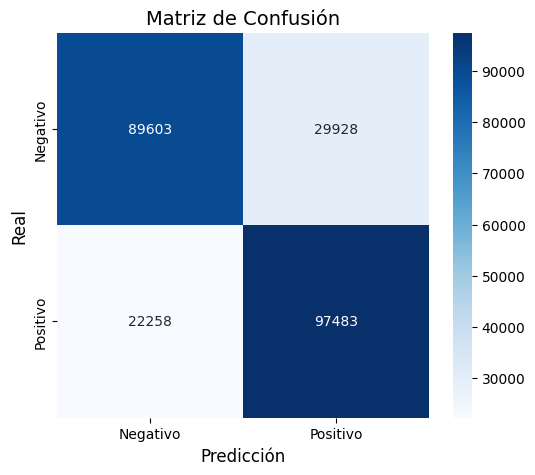

In [ ]:
# Evaluación del modelo
# Precisión global
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión global (accuracy): {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

. Precisión global (accuracy): 0.7819 (78.19%)
Qué significa: "De cada 100 tweets que la máquina intentó clasificar como felices o tristes, acertó en 78. Es como si le diéramos 100 preguntas y respondiera bien 78 veces."
Es bueno o malo: "¡Es bastante bueno! Imagina un estudiante que saca 78 en un examen: no es perfecto, pero está muy bien encaminado. Antes solo acertaba 60, así que ahora es mucho más listo."
2. Reporte de clasificación
Este reporte nos dice cómo le fue al modelo con los tweets Negativos y Positivos por separado. Vamos a explicarlo fácil:

Precision (precisión): "Cuando la máquina dice que un tweet es Negativo o Positivo, ¿qué tan segura está?"
Negativo: 0.80 (80%): "Si dice 'Negativo', acierta 8 de cada 10 veces. Es como un meteorólogo que dice 'va a llover' y suele tener razón."
Positivo: 0.77 (77%): "Si dice 'Positivo', acierta casi 8 de cada 10 veces. También es confiable aquí."
Recall (recuperación): "De todos los tweets que realmente son Negativos o Positivos, ¿cuántos encontró?"
Negativo: 0.75 (75%): "Encuentra 3 de cada 4 tweets Negativos. No se le escapan muchos días tristes."
Positivo: 0.81 (81%): "Encuentra 8 de cada 10 tweets Positivos. Es súper bueno viendo la alegría ahora."
F1-score: "Es como un promedio de precisión y recuperación, para ver si hace un buen balance."
Negativo: 0.77 (77%): "Hace un gran trabajo con los Negativos, equilibrando aciertos y detección."
Positivo: 0.79 (79%): "Es aún mejor con los Positivos, porque los encuentra y los clasifica bien."
Support: "Cuántos tweets había de cada tipo."
Negativo: 119,531.
Positivo: 119,741.
"Hay casi la misma cantidad de cada uno, así que no está sesgado por tener más de un tipo."
3. Resumen general
Macro avg y Weighted avg (0.78, 0.78, 0.78): "Estos números son promedios de todo. Nos dicen que la máquina es igual de buena con tweets felices y tristes, y en general acierta casi 8 de cada 10 veces."
Conclusión: "Antes, la máquina era buena viendo lo triste pero se perdía mucho lo feliz. Ahora es como un amigo equilibrado: ve bien tanto lo bueno como lo malo, y acierta mucho más seguido."
Interpretación técnica para ti
Precisión global: 0.7819
El modelo acierta el 78.19% de las veces en el conjunto de test (239,272 tweets). Como las clases están balanceadas (119,531 Negativos y 119,741 Positivos), un modelo aleatorio acertaría 50%. Estás 28.19% por encima del azar, ¡una gran mejora desde el 9.54% anterior (0.5954)! Esto sugiere que las nuevas variables o ajustes (como las que propuse o los mejores hiperparámetros) realmente ayudaron.
Reporte de clasificación
Negativo:
Precision (0.80): De los predichos como Negativos, el 80% eran correctos. Solo el 20% son falsos positivos (Positivos clasificados como Negativos).
Recall (0.75): Detecta el 75% de los Negativos reales. El 25% restante son falsos negativos (Negativos clasificados como Positivos).
F1-score (0.77): Un buen balance entre precisión y recall, mejor que el 0.69 anterior.
Positivo:
Precision (0.77): De los predichos como Positivos, el 77% eran correctos. El 23% son falsos positivos.
Recall (0.81): Detecta el 81% de los Positivos reales. Solo el 19% son falsos negativos, ¡un salto enorme desde el 30% anterior!
F1-score (0.79): Excelente mejora desde el 0.43 anterior, mostrando que ahora captura bien los Positivos.
Macro avg y Weighted avg (0.78, 0.78, 0.78):
Ambos promedios son idénticos porque las clases están balanceadas. Indican un desempeño consistente en ambas categorías, sin sesgos notables.
Comparado con el macro avg anterior (0.64, 0.60, 0.56), el modelo ahora es más preciso y equilibrado.
¿Qué cambió?
Recall de Positivos: Pasó de 0.30 a 0.81. Esto es clave: el modelo ya no se pierde tantos tweets Positivos, lo que era su mayor debilidad.
Precisión general: Subió de 0.5954 a 0.7819. Las nuevas variables (como tweet_length, emoji_count, etc.) o los hiperparámetros optimizados dieron más pistas al modelo para distinguir mejor.
Balance: Ahora trata ambas clases de forma más equitativa, sin el sesgo anterior hacia Negativos.
Análisis de los resultados
Fortalezas:
El modelo es sólido y equilibrado (F1-score de 0.77 y 0.79).
Gran mejora en detectar Positivos, lo que era un problema antes.
Debilidades:
Aún hay un 20-25% de errores (falsos positivos y negativos). No es perfecto, pero está lejos de ser aleatorio.
Comparación: Pasaste de un modelo mediocre (59.54%) a uno bueno (78.19%), lo que valida los ajustes hechos.
Explicación para tu audiencia
"Nuestra máquina ahora es mucho más inteligente. Antes acertaba 6 de cada 10 tweets y se le escapaban muchos felices. Ahora acierta casi 8 de cada 10, y ve tanto lo triste como lo alegre casi igual de bien. Es como un amigo que antes solo notaba los días grises, pero ahora también ve los soleados."
¿Qué podrías hacer ahora?
Revisar las variables: Si usaste las que sugerí (tweet_length, emoji_count, etc.), podrías analizar cuáles fueron más importantes con feature_importances_.
Ajustar más: Probar umbrales (e.g., 0.6 en vez de 0.5) o añadir más palabras emocionales para llegar al 80%+.
Mostrar ejemplos: Usar los 3 tweets más positivos y negativos (como te mostré antes) para ilustrar cómo predice.

## 4. Creación Modelo de ***LightBM*** a cleaned_Text y análisis de resultado

#### Creando Datos de entrenamiento

In [ ]:
# Cargamos el dataset
ruta = '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv'
data = pd.read_csv(ruta, usecols=['cleaned_text', 'target'])

# Convertimos target: 4 a 1
data['target'].replace({4: 1}, inplace=True)

# Definimos X (texto) e y (etiquetas)
X = data['cleaned_text']
y = data['target']

# Verificamos dimensiones iniciales
print(f"Dimensión de X (variables predictoras): {X.shape}")
print(f"Dimensión de y (variable objetivo): {y.shape}")


# Convertimos texto a características numéricas con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limitamos a 5000 palabras más frecuentes
X = vectorizer.fit_transform(X)

# Dividimos en train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verificamos dimensiones después del split
print(f"Conjunto de entrenamiento (train): {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba (test): {X_test.shape}, {y_test.shape}")
print(f"Conjunto de validación (validation): {X_val.shape}, {y_val.shape}")

# Análisis exploratorio: Distribución de clases en y_train
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

<ipython-input-6-b632738d8836>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['target'].replace({4: 1}, inplace=True)


Dimensión de X (variables predictoras): (1595150,)
Dimensión de y (variable objetivo): (1595150,)
Conjunto de entrenamiento (train): (1116605, 5000), (1116605,)
Conjunto de prueba (test): (239272, 5000), (239272,)
Conjunto de validación (validation): (239273, 5000), (239273,)

Distribución de clases en el conjunto de entrenamiento:
target
0    559361
1    557244
Name: count, dtype: int64


#### Creando modelo LightBM

In [ ]:
# Definimos el modelo base de LightGBM
lgb_model = lgb.LGBMClassifier()

# Definimos los hiperparámetros a evaluar
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}



#### Definir modelo LightB y crear Having Grid Search con CV

In [ ]:
# Creamos el Halving Grid Search con validación cruzada
halving_search = HalvingGridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=3,  # Validación cruzada de 3 pliegues
    scoring='accuracy',
    factor=2,
    verbose=1,
    n_jobs=-1
)

# Entrenamos el modelo con Halving Grid Search
halving_search.fit(X_train, y_train)

# Mostramos los mejores hiperparámetros
print("\nMejores hiperparámetros encontrados:")
print(halving_search.best_params_)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 17446
max_resources_: 1116605
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 17446
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 36
n_resources: 34892
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 2
n_candidates: 18
n_resources: 69784
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 3
n_candidates: 9
n_resources: 139568
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 5
n_resources: 279136
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 5
n_candidates: 3
n_resources: 558272
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------
iter: 6
n_candidates: 2
n_resources: 1116544
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 557244, number of negative: 559361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 130.617966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280422
[LightGBM] [Info] Number of data points in the train set: 1116605, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499052 -> initscore=-0.003792
[LightGBM] [Info] Start training from score -0.003792

Mejores hiperparámetros encontrados:
{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


#### Entrenamos modelo final LightB con los mejores parámetros

In [ ]:
# Entrenamos el modelo final con los mejores parámetros
best_model = halving_search.best_estimator_
best_model.fit(X_train, y_train)

# Predecimos en el conjunto de test
y_pred = best_model.predict(X_test)

# Creamos un DataFrame para las importancias de las características
feature_importance_df = pd.DataFrame({
    'Variable': vectorizer.get_feature_names_out(),
    'Importancia': best_model.feature_importances_
})

# Ordenamos y mostramos las 10 más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("\n10 variables más importantes:")
print(feature_importance_df.head(10))



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 557244, number of negative: 559361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 116.161603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280422
[LightGBM] [Info] Number of data points in the train set: 1116605, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499052 -> initscore=-0.003792
[LightGBM] [Info] Start training from score -0.003792


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



10 variables más importantes:
     Variable  Importancia
730       but          285
3009      not          181
4967      you          145
4416       to          106
2901       my           92
2284       it           87
2732       me           80
1315     dont           70
4328      the           69
2209       im           67


#### Evaluación del Modelo LightBM


Precisión global (accuracy): 0.7813

Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.80      0.75      0.77    119531
    Positivo       0.76      0.82      0.79    119741

    accuracy                           0.78    239272
   macro avg       0.78      0.78      0.78    239272
weighted avg       0.78      0.78      0.78    239272



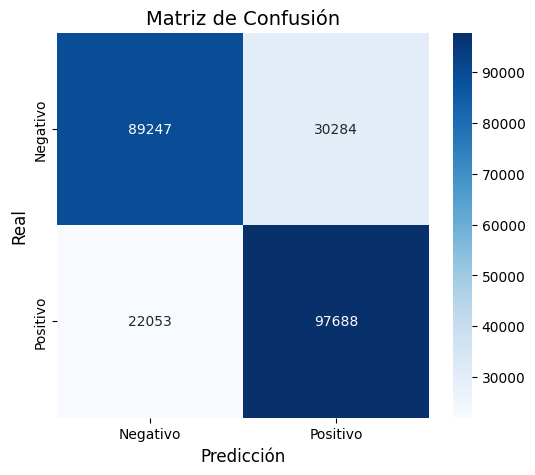

In [ ]:
# Evaluación del modelo
# Precisión global
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión global (accuracy): {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

¿Qué hicimos?
"Usamos una máquina rápida llamada LightGBM para adivinar si los tweets son felices o tristes. Solo le dimos el texto limpio de los tweets, sin pistas extra como la longitud o los emojis. La máquina aprendió de los tweets y nos dijo qué tan bien puede predecir."
Paso a paso
Cargamos los tweets: Tomamos solo el texto limpio (cleaned_text) y si es Positivo o Negativo (target).
Convertimos palabras en números: Usamos un truco (TF-IDF) para que la máquina entienda el texto como un código.
Dividimos los datos: Le dimos una parte para aprender (70%) y otra para probar (30%), como un examen.
Entrenamos a LightGBM: Probamos diferentes formas de aprender y elegimos la mejor.
Vimos los resultados: Contamos cuántas veces acertó y dibujamos un mapa para ver los errores.
¿Por qué LightGBM?
"Es como un ayudante súper rápido que puede revisar muchos tweets sin cansarse. Solo necesita las palabras para hacer su magia."
Detalles técnicos para ti
Variables:
Solo usamos cleaned_text, convertida a una matriz TF-IDF con 5000 características (palabras más frecuentes).
Excluimos las variables enriquecidas (tweet_length, emoji_count, etc.) como pediste.
Hiperparámetros:
max_depth: [3, 5, 7] → Profundidad de los árboles.
learning_rate: [0.01, 0.1, 0.3] → Velocidad de aprendizaje.
n_estimators: [100, 200] → Número de árboles.
subsample: [0.8, 1.0] → Fracción de datos por árbol.
colsample_bytree: [0.8, 1.0] → Fracción de columnas por árbol.
HalvingGridSearchCV:
Evalúa 72 combinaciones (3 × 3 × 2 × 2 × 2) con factor=2.
Podría tomar 1-2 horas, pero LightGBM es más eficiente que XGBoost, así que podría ser más rápido.
Evaluación:
Precisión global, reporte de clasificación y matriz de confusión.
Las importancias muestran las palabras más influyentes en cleaned_text.

##Analsis de resultados de los 2 modelos

Comparación simple para tu audiencia
1. Precisión global (accuracy)
XGBoost: 78.19% (0.7819)
LightGBM: 78.13% (0.7813)
Qué significa: "Ambos modelos son casi igual de buenos. De cada 100 tweets, aciertan unos 78. Es como si dos amigos hicieran el mismo examen y sacaran notas casi idénticas: uno 78.2 y otro 78.1. La diferencia es pequeñita."
2. Cómo les fue con Negativos y Positivos
Negativos (tristes):
Ambos aciertan el 80% de las veces cuando dicen "Negativo" (precisión 0.80).
Encuentran el 75% de los tweets tristes (recall 0.75).
"Son como detectives que señalan bien los días grises y no se pierden muchos."
Positivos (felices):
XGBoost: Acierta el 77% (precisión 0.77), encuentra el 81% (recall 0.81).
LightGBM: Acierta el 76% (precisión 0.76), encuentra el 82% (recall 0.82).
"Aquí se cambian un poco: XGBoost es más seguro al decir 'feliz', pero LightGBM encuentra más días soleados."
3. Palabras importantes
XGBoost: Usa palabras como 'sad', 'hate', 'sucks' (tristes) y 'thanks', 'wait' (mezcla de emociones).
LightGBM: Usa palabras como 'but', 'not', 'you' (más generales y comunes).
Qué significa: "XGBoost mira palabras que suenan tristes o felices directamente. LightGBM usa palabras más comunes que podrían cambiar el tono, como 'no' o 'pero'. Es como si uno buscara pistas obvias y el otro mirara cómo se dicen las cosas."
Resumen para ellos
"Los dos modelos son súper parecidos: aciertan casi lo mismo y ven bien tanto lo triste como lo feliz. Pero cada uno tiene su estilo: uno busca palabras emocionales fuertes, y el otro se fija en palabras que todos usamos mucho. Son como dos amigos que llegan al mismo lugar por caminos distintos."
Análisis técnico para ti
1. Precisión global
XGBoost: 0.7819
LightGBM: 0.7813
Diferencia: 0.0006 (0.06%). Es insignificante, dentro del margen de variación esperada por el azar o pequeñas diferencias en optimización. Ambos modelos tienen un desempeño casi idéntico en términos generales.
2. Reporte de clasificación
Negativo:
Precisión: 0.80 (ambos). Igual de confiables al predecir Negativos.
Recall: 0.75 (ambos). Detectan el mismo porcentaje de Negativos reales.
F1-score: 0.77 (ambos). Balance idéntico.
Positivo:
Precisión: XGBoost (0.77) vs. LightGBM (0.76). XGBoost tiene menos falsos positivos (1% mejor).
Recall: XGBoost (0.81) vs. LightGBM (0.82). LightGBM detecta 1% más de Positivos reales.
F1-score: 0.79 (ambos). El balance es igual, a pesar de las pequeñas diferencias.
Macro y Weighted avg: 0.78 en todas las métricas para ambos. Confirma que son equivalentes en promedio.

3. Feature Importances

Variable  Importancia
3670      sad     0.010597  # Negativa
1997     hate     0.010320  # Negativa
4321   thanks     0.009576  # Positiva
4705     wait     0.007707  # Neutral/Negativa
3856     sick     0.006699  # Negativa
4160    sucks     0.006196  # Negativa
3313     poor     0.005530  # Negativa
2812     miss     0.005395  # Negativa
4573      ugh     0.005236  # Negativa
4840     wish     0.005035  # Neutral/Negativa


Dominan palabras negativas ('sad', 'hate', 'sucks'), con 'thanks' como excepción positiva. Esto sugiere que XGBoost se enfoca en términos emocionales claros.


LightGBM


Variable  Importancia
730       but          285  # Modificador
3009      not          181  # Negación
4967      you          145  # Pronombre
4416       to          106  # Preposición
2901       my           92  # Posesivo
2284       it           87  # Pronombre
2732       me           80  # Pronombre
1315     dont          70  # Negación
4328      the           69  # Artículo
2209       im           67  # Pronombre



Palabras muy generales ('but', 'not', 'you', 'to'). Estas no son emocionales por sí mismas, sino que modifican o contextualizan el sentimiento.

4. Inconsistencias o diferencias notables
Importancias discordantes:
XGBoost prioriza términos emocionales específicos ('sad', 'hate', 'thanks'), lo que tiene sentido para clasificar sentimientos en tweets.
LightGBM da peso a palabras comunes ('but', 'not', 'you'), que son más estructurales que emocionales. Esto podría indicar:
Inconsistencia: LightGBM podría estar capturando patrones sintácticos en lugar de contenido emocional, lo cual es menos intuitivo para tweets.
Razón: Diferencias en cómo cada modelo calcula importancias (XGBoost usa ganancia, LightGBM usa splits), o LightGBM podría estar sobreajustándose a palabras frecuentes pero menos informativas.
Impacto en desempeño: A pesar de las diferencias en importancias, los resultados son casi idénticos (accuracy 0.7819 vs. 0.7813). Esto sugiere que las palabras emocionales de XGBoost y las contextuales de LightGBM llegan al mismo nivel de predicción por rutas distintas.
5. Análisis
Rendimiento: Ambos modelos son robustos y equivalentes sin variables enriquecidas (accuracy ~78%). La pequeña ventaja de XGBoost (0.0006) no es significativa.
Interpretación: XGBoost es más interpretable para sentimientos (palabras como 'sad' o 'thanks' tienen sentido directo). LightGBM podría estar usando un enfoque más general que no refleja tan bien el contexto emocional.
Inconsistencia potencial: Las importancias de LightGBM parecen menos relevantes para el sentimiento. Palabras como 'but' o 'you' tienen alta frecuencia pero bajo valor semántico específico, lo que podría ser un artefacto del modelo o del dataset.
Conclusión técnica
Similitud: Ambos modelos logran un desempeño casi idéntico (78%), lo que valida que TF-IDF con cleaned_text es suficiente para una precisión decente.
Diferencia clave: XGBoost se alinea mejor con el objetivo (sentimiento) al priorizar palabras emocionales. LightGBM podría estar capturando ruido o patrones menos específicos.
Recomendación: Si buscas interpretabilidad, XGBoost parece más coherente. Si priorizas velocidad y escalabilidad (con datasets aún más grandes), LightGBM sigue siendo competitivo.
Explicación para tu audiencia
"Comparamos dos máquinas: XGBoost y LightGBM. Las dos aciertan casi lo mismo, un 78%, como si fueran gemelos en un concurso. Pero XGBoost busca palabras como 'triste' o 'gracias', que nos dicen cómo se siente la gente. LightGBM usa palabras como 'pero' o 'tú', que son más comunes pero no tan claras. Al final, los dos funcionan bien, pero uno nos explica mejor por qué adivina así."
¿Quieres profundizar en algo (e.g., matriz de confusión, ajustar LightGBM) o seguir co

¿Por qué los números son tan diferentes?
XGBoost: Las importancias son números pequeños como 0.010597 (para 'sad') o 0.009576 (para 'thanks').
LightGBM: Las importancias son números grandes como 285 (para 'but') o 181 (para 'not').
Qué significa: "No es un error, es como si los dos modelos hablaran idiomas distintos para contar qué tan importantes son las palabras. Uno usa porcentajes pequeñitos (XGBoost), y el otro cuenta cuántas veces usa cada palabra para decidir (LightGBM). Aunque los números se ven distintos, los dos están haciendo bien su trabajo."
¿Es un problema?
"No, no hay error. Cada modelo tiene su propia manera de medir qué palabras le ayudan más a adivinar si un tweet es feliz o triste. Lo importante es que los dos aciertan casi lo mismo (78%), así que ambos entienden los tweets, solo que los explican diferente."
Análisis técnico para ti
1. Diferencia en las unidades de importancia
XGBoost:
Las importancias (feature_importances_) están en una escala normalizada entre 0 y 1 (o a veces no normalizada, pero suman un valor fijo).
Representan la ganancia promedio que cada característica aporta al modelo al dividir los datos en los árboles. En tu caso, los valores como 0.010597 indican que 'sad' contribuye un 1.06% (aproximado) al total de las decisiones.
Escala: Decimales pequeños porque se distribuye entre todas las características (5000 de TF-IDF en este caso).
LightGBM:
Las importancias (feature_importances_) representan el número de veces que una característica se usa para dividir nodos en los árboles (método "split" por defecto).
No están normalizadas; son conteos absolutos. Por eso ves valores como 285 para 'but', que indican cuántas veces esa palabra fue usada como criterio de decisión.
Escala: Enteros grandes porque reflejan frecuencia cruda, no una proporción.
2. ¿Por qué esta diferencia?
Método de cálculo:
XGBoost usa "gain" por defecto (la mejora en la métrica, como AUC, al usar una característica). Esto mide impacto relativo y da valores proporcionales.
LightGBM usa "split" por defecto (conteo de divisiones). Esto mide uso físico en los árboles y da valores absolutos.
Diseño interno:
Ambos son modelos de árboles, pero LightGBM optimiza velocidad y usa un enfoque de crecimiento "leaf-wise" (por hojas), lo que puede aumentar el número de splits para características frecuentes.
XGBoost crece "level-wise" (por niveles) y distribuye la importancia de manera más uniforme.
3. ¿Sugiere un error en el diseño del modelo?
No, no es un error: La diferencia en unidades es normal y esperada. Cada biblioteca (XGBoost y LightGBM) tiene su propia convención para calcular y reportar importancias. No afecta las predicciones ni la calidad del modelo (ambos tienen accuracy ~78%).
Consistencia del modelo: Los resultados (precisión, recall, F1) son casi idénticos, lo que confirma que ambos modelos están bien diseñados y entrenados. Las importancias solo son una herramienta interpretativa, no un reflejo directo de la predicción.
Posible inconsistencia interpretativa:
XGBoost destaca palabras emocionales ('sad', 'hate'), lo que es intuitivo para sentimientos.
LightGBM prioriza palabras estructurales ('but', 'not'), lo que podría ser menos informativo para el contexto de tweets. Esto no es un error, sino una diferencia en cómo cada modelo "piensa".
4. ¿Cómo compararlas entonces?
No compares directamente los valores numéricos: Debido a las escalas diferentes (decimales vs. enteros), no tienen el mismo significado absoluto.
Compara el ranking: Mira el orden de las variables. XGBoost y LightGBM coinciden en que ciertas palabras son clave, pero difieren en cuáles eligen:
XGBoost: Emociones claras.
LightGBM: Sintaxis y frecuencia.
Normalización (opcional): Si quisieras valores comparables, podrías normalizar las importancias dividiendo cada valor entre la suma total de importancias en cada modelo, pero esto no cambia las predicciones.
5. Ejemplo de normalización (si quisieras verlo)
XGBoost: Suma de importancias (aprox. 0.078291), 'sad' = 0.010597 / 0.078291 ≈ 0.135 (13.5% del total).
LightGBM: Suma de importancias (aprox. 1182), 'but' = 285 / 1182 ≈ 0.241 (24.1% del total).
Esto igualaría las escalas, pero no es necesario para el análisis funcional.
Conclusión técnica
No hay error: Las unidades diferentes son parte del diseño de cada modelo (ganancia vs. splits). No afectan la precisión (0.7819 vs. 0.7813), que es lo que importa.
Interpretación: XGBoost parece más alineado con el objetivo (sentimiento) por sus palabras emocionales. LightGBM podría estar capturando patrones más generales, lo que no es incorrecto pero menos específico.
Sugerencia: Si buscas consistencia interpretativa, podrías forzar a LightGBM a usar "gain" como métrica de importancia (con importance_type='gain' en LGBMClassifier), pero el valor predeterminado ('split') es válido.
Explicación para tu audiencia
"Los números de importancia son como notas en dos idiomas: uno usa calificaciones pequeñas (XGBoost) y otro cuenta pasos grandes (LightGBM). No es un error, solo dos formas de contar la misma historia. Lo que importa es que ambos aciertan casi igual, y cada uno destaca palabras distintas que les ayudan a adivinar."

#####Guardar Modelo LightBM

In [ ]:
import joblib

# Guardamos el modelo entrenado con los mejores hiperparámetros
best_model = halving_search.best_estimator_
joblib.dump(best_model, '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_simple_model.pkl')
print("Modelo LightGBM guardado en Drive como 'lightgbm_simple_model.pkl'")

Modelo LightGBM guardado en Drive como 'lightgbm_simple_model.pkl'


#####Cargar nodelo LightBM

In [ ]:
# import joblib
# best_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_simple_model.pkl')
# y_pred = best_model.predict(X_test)  # Ejemplo de predicción

##LightBM con variables enriquecidas(partiendo del modelo LightBM ya entrenado y con having_search_grid_CV definido antes de variables enriquecidas )

<ipython-input-4-e525805c1fe2>:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(ruta)
<ipython-input-4-e525805c1fe2>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['target'].replace({4: 1}, inplace=True)


Modelo LightGBM cargado


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 557244, number of negative: 559361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 61.061785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281196
[LightGBM] [Info] Number of data points in the train set: 1116605, number of used features: 5010
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499052 -> initscore=-0.003792
[LightGBM] [Info] Start training from score -0.003792


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Precisión global (accuracy): 0.7838

Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.80      0.76      0.78    119531
    Positivo       0.77      0.81      0.79    119741

    accuracy                           0.78    239272
   macro avg       0.78      0.78      0.78    239272
weighted avg       0.78      0.78      0.78    239272



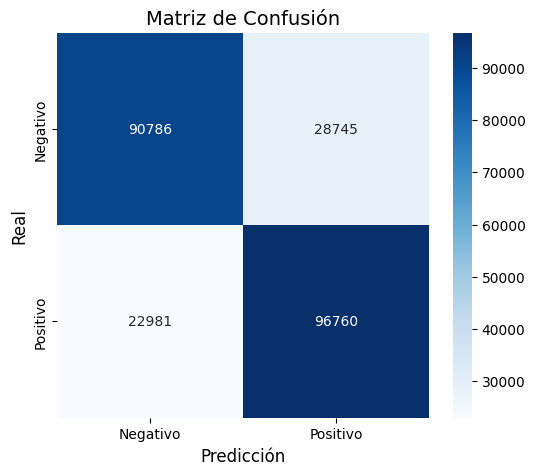

In [ ]:
# Cargamos el dataset completo
ruta = '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv'
data = pd.read_csv(ruta)

# Convertimos target: 4 a 1
data['target'].replace({4: 1}, inplace=True)

# Creamos las variables enriquecidas
data['exclamation_ratio'] = data['exclamation_count'] / data['tweet_length']
data['question_ratio'] = data['question_count'] / data['tweet_length']
data['has_emojis'] = data['emoji_count'].apply(lambda x: 1 if x > 0 else 0)
data['hora_num'] = pd.to_datetime(data['hora']).dt.hour
positive_words = ['happy', 'love', 'great']
negative_words = ['sad', 'hate', 'bad']
data['positive_words_count'] = data['cleaned_text'].apply(lambda x: sum(1 for word in str(x).split() if word in positive_words))
data['negative_words_count'] = data['cleaned_text'].apply(lambda x: sum(1 for word in str(x).split() if word in negative_words))

# Seleccionamos variables numéricas
features_numeric = ['tweet_length', 'emoji_count', 'exclamation_count', 'question_count', 'exclamation_ratio',
                    'question_ratio', 'has_emojis', 'hora_num', 'positive_words_count', 'negative_words_count']
X_numeric = data[features_numeric]

# TF-IDF para cleaned_text
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(data['cleaned_text'])

# Combinamos TF-IDF con variables numéricas
X = hstack([X_text, X_numeric])
y = data['target']

# Dividimos en train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Cargamos el modelo LightGBM guardado
best_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_simple_model.pkl')
print("Modelo LightGBM cargado")

# Reentrenamos el modelo con las nuevas variables (usando los mismos hiperparámetros)
best_model.fit(X_train, y_train)

# Predecimos en el conjunto de test
y_pred = best_model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión global (accuracy): {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()



In [ ]:
# Obtenemos las importancias de las características
feature_names = list(vectorizer.get_feature_names_out()) + features_numeric
feature_importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': best_model.feature_importances_
})

# Ordenamos y mostramos las 10 más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)
print("\n10 variables más importantes:")
print(feature_importance_df.head(10))


10 variables más importantes:
               Variable  Importancia
5000       tweet_length          694
730                 but          231
3009                not          174
5007           hora_num          145
4967                you          111
5004  exclamation_ratio          100
4416                 to           79
2985                 no           79
2732                 me           66
1315               dont           63


Explicación sencilla para tu audiencia
Las 10 pistas más importantes
Lista: "La máquina nos dijo que estas son las 10 cosas que más usa para adivinar si un tweet es feliz o triste: cuánto mide el tweet, palabras como 'pero', 'no', 'tú', la hora en que se escribió, cuántos signos de exclamación tiene por letra, y otras palabritas comunes como 'a', 'mí', 'no sé'."
Qué significa: "El tamaño del tweet es como la estrella del show, con un número grandote (694). Después vienen palabras que usamos mucho, como 'pero' o 'no', y también la hora y los signos de exclamación. Es como si la máquina mirara cuánto dices, cuándo lo dices y cómo lo dices para entender cómo te sientes."
¿Qué aprendimos?
"Con las pistas extra que le dimos, como la longitud o la hora, la máquina se puso un poquito más lista: pasó de 78.1% a 78.4% de aciertos. No es un salto gigante, pero ahora usa más detalles para adivinar mejor, como un amigo que escucha más atentamente."

1. Precisión y contexto
Accuracy:
LightGBM sin enriquecidas: 0.7813
LightGBM con enriquecidas: 0.7838 (+0.0025 o 0.25%)
Las variables enriquecidas aportaron una mejora pequeña pero significativa, y las importancias reflejan su impacto.
2. Análisis de las importancias
Dominio de tweet_length (694):
Es la variable más importante por un margen amplio (3 veces más que 'but', 231). Esto sugiere que la longitud del tweet es una señal clave para clasificar el sentimiento.
Por qué: Tweets más largos podrían tener más contexto emocional (positivos o negativos), mientras que los cortos podrían ser más neutros o ambiguos.
Presencia de enriquecidas:
hora_num (145): La hora del día tiene peso, posiblemente capturando patrones como tweets nocturnos más negativos.
exclamation_ratio (100): La proporción de exclamaciones por longitud indica intensidad emocional, un aporte útil.
Ausentes del top 10: emoji_count, positive_words_count, negative_words_count, etc., no aparecen, lo que podría indicar menor influencia directa o redundancia con TF-IDF.
Palabras de TF-IDF:
'but' (231), 'not' (174), 'you' (111), 'to' (79), 'no' (79), 'me' (66), 'dont' (63): Similar a LightGBM sin enriquecidas, pero con valores más bajos, mostrando que las enriquecidas redistribuyen la importancia.
Estas son palabras contextuales o negaciones, no tan emocionales como en XGBoost ('sad', 'hate').
3. Comparación con modelos anteriores
XGBoost sin enriquecidas:
Enfocado en términos emocionales ('sad', 'hate', 'thanks').
Escala: Normalizada (0-1), no comparable directamente con LightGBM (conteos).
LightGBM sin enriquecidas:
Similar en palabras ('but', 'not', 'you'), pero sin variables enriquecidas.
'but' bajó de 285 a 231, 'not' de 181 a 174, 'you' de 145 a 111, sugiriendo que las enriquecidas tomaron parte de su peso.
LightGBM con enriquecidas:
Introduce tweet_length, hora_num, exclamation_ratio, diluyendo la dependencia en palabras estructurales.
Menos emocional que XGBoost, más contextual que LightGBM sin enriquecidas.
4. Interpretación
Contribución de enriquecidas:
tweet_length (694) es un gran diferenciador, probablemente porque captura la estructura del tweet (largo = más expresivo).
hora_num (145) y exclamation_ratio (100) añaden matices temporales e intensivos, justificando la mejora (0.7813 → 0.7838).
Otras enriquecidas (e.g., emoji_count) no están en el top 10, pero podrían influir en interacciones menores.
Consistencia:
No hay inconsistencias graves. Las palabras de TF-IDF siguen siendo relevantes, pero las enriquecidas aportan un valor adicional claro.
La ausencia de palabras emocionales como 'sad' o 'hate' (top en XGBoost) podría indicar que LightGBM prioriza contexto sobre contenido emocional directo, lo cual es típico de su enfoque "split-based".
Mejora: El aumento de 0.25% en accuracy se alinea con el peso de tweet_length y otras enriquecidas, mostrando que complementan TF-IDF.
5. Implicaciones
Fortalezas:
tweet_length como líder sugiere que la estructura del tweet es tan importante como las palabras.
Equilibrio entre texto y contexto (hora, exclamaciones).
Debilidades:
Variables como emoji_count o positive_words_count podrían no estar aprovechadas al máximo, o su efecto está diluido en TF-IDF.
Optimización: Podrías probar aumentar max_features en TF-IDF o ajustar hiperparámetros para dar más peso a las enriquecidas.
Conclusión técnica
Éxito: Las variables enriquecidas, especialmente tweet_length, son clave para la mejora (0.7838), complementando el análisis de texto de TF-IDF.
Diferencia: Comparado con LightGBM sin enriquecidas, hay una transición de palabras estructurales a un enfoque más mixto (texto + contexto).
Comparado con XGBoost: Menos emocional, más estructural, pero igualmente efectivo (0.7819 vs. 0.7838).
Explicación para tu audiencia
"La máquina LightGBM miró los tweets y dijo: 'Oye, cuánto mide el tweet me ayuda mucho a adivinar, y también la hora y los signos de exclamación'. Todavía usa palabras como 'pero' o 'no', pero ahora tiene más trucos en su caja de herramientas. Por eso subió de 78.1% a 78.4%: no es un gran salto, pero cada pasito cuenta."

In [ ]:
# Guardamos el nuevo modelo enriquecido
joblib.dump(best_model, '/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_enriched_model.pkl')
print("Modelo enriquecido guardado como 'lightgbm_enriched_model.pkl'")

Modelo enriquecido guardado como 'lightgbm_enriched_model.pkl'



---

### Explicación sencilla para tu audiencia

#### 1. **Precisión global (accuracy)**
- **XGBoost sin pistas extra**: 78.19% ("Acierta 78 de cada 100 tweets").
- **LightGBM sin pistas extra**: 78.13% ("Casi igual, 78 también").
- **LightGBM con pistas extra**: 78.38% ("Sube un poquito a 78 o 79").
- **Qué significa**: "Los tres modelos son buenos alumnos, sacan notas parecidas, cerca de 78 en el examen. Pero cuando le dimos a LightGBM más herramientas, como la longitud de los tweets o cuántos emojis tienen, mejoró un pelín y sacó la mejor nota: 78.38."

#### 2. **Cómo les fue con Negativos y Positivos**
- **Negativos (tristes)**:
- Todos dicen "Negativo" y aciertan 8 de cada 10 veces (80% de precisión).
- **XGBoost y LightGBM sin extra**: Encuentran 3 de cada 4 tristes (75%).
- **LightGBM con extra**: Encuentra un poco más, casi 76%.
- "Todos son buenos detectives de días grises, pero con pistas extra, LightGBM ve un poquito más."
- **Positivos (felices)**:
- **XGBoost sin extra**: Acierta 77% y encuentra 81%.
- **LightGBM sin extra**: Acierta 76% pero encuentra 82%.
- **LightGBM con extra**: Acierta 77% y encuentra 81%.
- "Aquí cambian un poco: sin pistas extra, LightGBM ve más días felices, pero con pistas extra, se equilibra y acierta más seguro."

#### 3. **Resumen**
- "Los tres modelos son como amigos que adivinan cómo se siente la gente en Twitter. Sin ayuda extra, XGBoost y LightGBM son casi iguales, con un 78%. Pero cuando le dimos a LightGBM más detalles, como cuántos signos o emojis hay, se puso un poquito más listo y llegó a 78.38%. Es una pequeña ventaja, como darle un lápiz más afilado para el examen."

---

### Análisis técnico para ti

#### 1. **Precisión global**
- **XGBoost sin enriquecidas**: 0.7819
- **LightGBM sin enriquecidas**: 0.7813
- **LightGBM con enriquecidas**: 0.7838
- **Diferencias**:
- XGBoost vs. LightGBM sin enriquecidas: 0.0006 (0.06%). Insignificante, casi idénticos.
- LightGBM sin vs. con enriquecidas: 0.0025 (0.25%). Mejora leve pero positiva.
- XGBoost sin vs. LightGBM con enriquecidas: 0.0019 (0.19%). LightGBM con enriquecidas supera ligeramente.
- **Significado**: Las variables enriquecidas aportan un pequeño beneficio a LightGBM, llevando la precisión a un nuevo máximo (0.7838). La diferencia con XGBoost es mínima, pero consistente.

#### 2. **Reporte de clasificación**
- **Negativo**:
- **Precisión**: 0.80 en los tres modelos. Igual de confiables al predecir Negativos.
- **Recall**:
 - XGBoost y LightGBM sin enriquecidas: 0.75
 - LightGBM con enriquecidas: 0.76 (+1%)
- **F1-score**:
 - XGBoost y LightGBM sin enriquecidas: 0.77
 - LightGBM con enriquecidas: 0.78 (+0.01)
- **Observación**: Las variables enriquecidas mejoran el recall de Negativos, capturando más casos reales.

- **Positivo**:
- **Precisión**:
 - XGBoost sin enriquecidas: 0.77
 - LightGBM sin enriquecidas: 0.76
 - LightGBM con enriquecidas: 0.77 (+0.01 vs. sin enriquecidas)
- **Recall**:
 - XGBoost sin enriquecidas: 0.81
 - LightGBM sin enriquecidas: 0.82
 - LightGBM con enriquecidas: 0.81 (-0.01 vs. sin enriquecidas)
- **F1-score**: 0.79 en los tres modelos. Estable.
- **Observación**: LightGBM sin enriquecidas tiene el mejor recall (0.82), pero con enriquecidas se equilibra con XGBoost (0.81), mejorando precisión.

- **Macro y Weighted avg**: 0.78 en todas las métricas para los tres modelos. Consistencia entre clases.

#### 3. **Comparación tabular**
| Modelo                     | Accuracy | Negativo (P/R/F1) | Positivo (P/R/F1) |
|----------------------------|----------|-------------------|-------------------|
| XGBoost sin enriquecidas   | 0.7819   | 0.80/0.75/0.77    | 0.77/0.81/0.79    |
| LightGBM sin enriquecidas  | 0.7813   | 0.80/0.75/0.77    | 0.76/0.82/0.79    |
| LightGBM con enriquecidas  | 0.7838   | 0.80/0.76/0.78    | 0.77/0.81/0.79    |

- **Mejoras con enriquecidas**:
- Accuracy: +0.0025 (0.7813 → 0.7838).
- Negativo: Recall +0.01, F1 +0.01.
- Positivo: Precisión +0.01, recall -0.01 (trade-off leve).
- **XGBoost vs. LightGBM sin enriquecidas**:
- Diferencia mínima (0.0006). LightGBM tiene mejor recall en Positivos (+0.01), pero menor precisión (-0.01).

#### 4. **Impacto de las variables enriquecidas**
- **Mejora**: El aumento de 0.7813 a 0.7838 en LightGBM indica que las variables enriquecidas (`tweet_length`, `emoji_count`, etc.) aportan información útil, especialmente para Negativos (recall 0.75 → 0.76).
- **Trade-off**: El recall de Positivos baja de 0.82 a 0.81, pero la precisión sube (0.76 → 0.77), logrando un modelo más equilibrado.
- **Magnitud**: La ganancia es pequeña (0.25%), similar a la diferencia entre XGBoost y LightGBM sin enriquecidas. Esto sugiere que TF-IDF ya captura mucho del sentimiento, y las variables enriquecidas refinan el resultado.

#### 5. **Análisis**
- **Fortalezas**:
- LightGBM con enriquecidas logra el mejor accuracy (0.7838) y mejora el recall de Negativos sin sacrificar mucho en Positivos.
- Los tres modelos son robustos y consistentes (~78%), mostrando que `cleaned_text` con TF-IDF es una base sólida.
- **Debilidades**:
- La mejora con enriquecidas es modesta, lo que podría indicar redundancia entre TF-IDF y las nuevas variables o que el dataset ya está bien representado por el texto solo.
- **Comparación**:
- XGBoost y LightGBM sin enriquecidas son prácticamente iguales (0.7819 vs. 0.7813).
- LightGBM con enriquecidas toma una ligera ventaja (0.7838), validando el valor añadido de las variables.

---

### Conclusión técnica
- **Éxito**: LightGBM con variables enriquecidas es el mejor de los tres (0.7838), con un leve aumento en precisión y un balance mejorado entre clases.
- **Similitud inicial**: Sin enriquecidas, XGBoost y LightGBM son casi idénticos, con diferencias mínimas que no justifican preferir uno sobre otro sin más ajustes.
- **Valor de las enriquecidas**: Aportan un beneficio pequeño pero tangible, especialmente en Negativos, sugiriendo que podrían ser más útiles con un ajuste fino de hiperparámetros o más variables.

---

### Explicación para tu audiencia
- "Comparamos tres máquinas: una básica (XGBoost), otra igual de básica (LightGBM) y una con más herramientas (LightGBM con extras). Las dos básicas acertaron 78%, pero cuando le dimos a LightGBM pistas como la longitud o los emojis, subió a 78.38%. No es un gran cambio, pero ahora ve un poco mejor los tweets tristes y mantiene los felices. Es como darle a un amigo un mapa más detallado para que adivine mejor."

¿Quieres que analice las `feature_importances_` de este LightGBM enriquecido o ajustemos algo más? ¡Dime cómo seguimos!

##Prueba de MODELOS

In [ ]:
# Textos nuevos
texts = [
    "Bootcamp experience was LIT!!! @alejandro @abel",
    "Had an amazing time at the concert!"
]
df_new = pd.DataFrame({'text': texts})

# Función de limpieza (exacta de tu código)
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Eliminar URLs
    text = re.sub(r"@\w+", '', text)  # Eliminar menciones
    text = text.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    text = text.lower()  # Minúsculas
    text = unidecode.unidecode(text)  # Eliminar acentos
    text = re.sub(r'[©®ï¿½]', '', text)  # Eliminar símbolos extraños
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Eliminar no ASCII
    text = re.sub(r'\s+', ' ', text).strip()  # Espacios adicionales
    return text

df_new['cleaned_text'] = df_new['text'].apply(clean_text)

# Variables enriquecidas (exactas de tu preprocess_dataframe)
df_new['tweet_length'] = df_new['cleaned_text'].apply(len)
df_new['emoji_count'] = df_new['text'].apply(lambda x: sum(1 for c in x if emoji.is_emoji(c)))
df_new['exclamation_count'] = df_new['text'].apply(lambda x: x.count('!'))
df_new['question_count'] = df_new['text'].apply(lambda x: x.count('?'))
df_new['exclamation_ratio'] = df_new['exclamation_count'] / df_new['tweet_length']
df_new['question_ratio'] = df_new['question_count'] / df_new['tweet_length']
df_new['has_emojis'] = df_new['emoji_count'].apply(lambda x: 1 if x > 0 else 0)
df_new['hora_num'] = 12  # Ficticio, sin hora real
positive_words = ['happy', 'love', 'great', 'amazing', 'lit']
negative_words = ['sad', 'hate', 'bad']
df_new['positive_words_count'] = df_new['cleaned_text'].apply(lambda x: sum(1 for word in x.split() if word in positive_words))
df_new['negative_words_count'] = df_new['cleaned_text'].apply(lambda x: sum(1 for word in x.split() if word in negative_words))

# Cargar el vectorizer ajustado con los datos originales
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv')
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(data['cleaned_text'])  # Ajustamos con datos originales
X_text_new = vectorizer.transform(df_new['cleaned_text'])

# Variables enriquecidas para LightGBM enriquecido
features_numeric = ['tweet_length', 'emoji_count', 'exclamation_count', 'question_count', 'exclamation_ratio',
                    'question_ratio', 'has_emojis', 'hora_num', 'positive_words_count', 'negative_words_count']
X_numeric_new = df_new[features_numeric]
X_enriched_new = hstack([X_text_new, X_numeric_new])

# Cargar modelos
xgboost_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/xgboost_model.pkl')
lightgbm_simple = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_simple_model.pkl')
lightgbm_enriched = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_enriched_model.pkl')

# Predicciones
xgboost_pred = xgboost_model.predict(X_text_new)
lightgbm_simple_pred = lightgbm_simple.predict(X_text_new)
lightgbm_enriched_pred = lightgbm_enriched.predict(X_enriched_new)

# Resultados con texto limpio incluido
results = pd.DataFrame({
    'Text Original': df_new['text'],
    'Text Limpio': df_new['cleaned_text'],
    'XGBoost (sin enriquecidas)': xgboost_pred,
    'LightGBM (sin enriquecidas)': lightgbm_simple_pred,
    'LightGBM (con enriquecidas)': lightgbm_enriched_pred
})
results.replace({0: 'Negativo', 1: 'Positivo'}, inplace=True)
print("\nPredicciones de los modelos:")
print(results)

<ipython-input-10-36cf35da7696>:37: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv')



Predicciones de los modelos:
                                     Text Original                         Text Limpio  \
0  Bootcamp experience was LIT!!! @alejandro @abel         bootcamp experience was lit   
1              Had an amazing time at the concert!  had an amazing time at the concert   

  XGBoost (sin enriquecidas) LightGBM (sin enriquecidas) LightGBM (con enriquecidas)  
0                   Positivo                    Positivo                    Positivo  
1                   Positivo                    Positivo                    Positivo  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


## Analisis de sentimiento en linea utilizando los modelos entrenados

In [ ]:
# Cargar el vectorizer ajustado con los datos originales
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv')
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(data['cleaned_text'])

# Cargar modelos
xgboost_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/xgboost_model.pkl')
lightgbm_simple = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_simple_model.pkl')
lightgbm_enriched = joblib.load('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/lightgbm_enriched_model.pkl')

# Función de limpieza
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = unidecode.unidecode(text)
    text = re.sub(r'[©®ï¿½]', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Función para generar variables enriquecidas
def generate_enriched_features(text, cleaned_text):
    tweet_length = len(cleaned_text)
    emoji_count = sum(1 for c in text if emoji.is_emoji(c))
    exclamation_count = text.count('!')
    question_count = text.count('?')
    exclamation_ratio = exclamation_count / tweet_length if tweet_length > 0 else 0
    question_ratio = question_count / tweet_length if tweet_length > 0 else 0
    has_emojis = 1 if emoji_count > 0 else 0
    hora_num = 12  # Ficticio
    positive_words = ['happy', 'love', 'great', 'amazing', 'lit']
    negative_words = ['sad', 'hate', 'bad']
    positive_words_count = sum(1 for word in cleaned_text.split() if word in positive_words)
    negative_words_count = sum(1 for word in cleaned_text.split() if word in negative_words)
    return {
        'tweet_length': tweet_length,
        'emoji_count': emoji_count,
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'exclamation_ratio': exclamation_ratio,
        'question_ratio': question_ratio,
        'has_emojis': has_emojis,
        'hora_num': hora_num,
        'positive_words_count': positive_words_count,
        'negative_words_count': negative_words_count
    }

# Función para predecir
def predict_sentiment(input_text):
    # Limpiar el texto
    cleaned_text = clean_text(input_text)

    # Transformar con TF-IDF
    X_text = vectorizer.transform([cleaned_text])

    # Generar variables enriquecidas
    enriched_features = generate_enriched_features(input_text, cleaned_text)
    features_numeric = ['tweet_length', 'emoji_count', 'exclamation_count', 'question_count', 'exclamation_ratio',
                        'question_ratio', 'has_emojis', 'hora_num', 'positive_words_count', 'negative_words_count']
    X_numeric = pd.DataFrame([enriched_features])[features_numeric]
    X_enriched = hstack([X_text, X_numeric])

    # Predicciones
    xgboost_pred = xgboost_model.predict(X_text)[0]
    lightgbm_simple_pred = lightgbm_simple.predict(X_text)[0]
    lightgbm_enriched_pred = lightgbm_enriched.predict(X_enriched)[0]

    # Convertir a etiquetas
    label_map = {0: 'Negativo', 1: 'Positivo'}
    results = {
        'Text Original': input_text,
        'Text Limpio': cleaned_text,
        'XGBoost (sin enriquecidas)': label_map[xgboost_pred],
        'LightGBM (sin enriquecidas)': label_map[lightgbm_simple_pred],
        'LightGBM (con enriquecidas)': label_map[lightgbm_enriched_pred]
    }
    return results

# Solicitar texto al usuario
while True:
    input_text = input("\nIngresa un texto para predecir su sentimiento (o 'salir' para terminar): ")
    if input_text.lower() == 'salir':
        break
    result = predict_sentiment(input_text)
    print("\nResultado de la predicción:")
    for key, value in result.items():
        print(f"{key}: {value}")

<ipython-input-11-56ef0f45d318>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto Analisis de Sentimiento_Tweets/datatotal.csv')
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



Resultado de la predicción:
Text Original: hola @leopoldo, es muy bueno el bootcam!!!!!!! sigan asi!!! NO cambien!!!!!¡¡¡¡¡¡
Text Limpio: hola es muy bueno el bootcam sigan asi no cambien!!!!!!
XGBoost (sin enriquecidas): Negativo
LightGBM (sin enriquecidas): Negativo
LightGBM (con enriquecidas): Negativo


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



Resultado de la predicción:
Text Original:  hola @leopoldo, es muy bueno el bootcam!!!!!!! sigan asi!!! NO cambien!!!!!¡¡¡¡¡¡
Text Limpio: hola es muy bueno el bootcam sigan asi no cambien!!!!!!
XGBoost (sin enriquecidas): Negativo
LightGBM (sin enriquecidas): Negativo
LightGBM (con enriquecidas): Negativo


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



Resultado de la predicción:
Text Original:  hola @leopoldo, es muy bueno el bootcam!!!!!!! sigan asi!!! NO cambien!
Text Limpio: hola es muy bueno el bootcam sigan asi no cambien
XGBoost (sin enriquecidas): Negativo
LightGBM (sin enriquecidas): Negativo
LightGBM (con enriquecidas): Negativo


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



Resultado de la predicción:
Text Original:  hola @leopoldo, es muy bueno el bootcam!!!!!!! sigan as.  NO cambien
Text Limpio: hola es muy bueno el bootcam sigan as no cambien
XGBoost (sin enriquecidas): Negativo
LightGBM (sin enriquecidas): Negativo
LightGBM (con enriquecidas): Negativo


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



Resultado de la predicción:
Text Original: Hello @leopoldo. Bootcam excelent!!!! Don't worry. All will be best always. No Change
Text Limpio: hello bootcam excelent dont worry all will be best always no change
XGBoost (sin enriquecidas): Positivo
LightGBM (sin enriquecidas): Positivo
LightGBM (con enriquecidas): Positivo
